In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from scipy.stats import gaussian_kde
import plotly.colors
from plotly.colors import qualitative
from pandas.tseries.offsets import BDay
import torch
import ast
import re

from dotenv.main import load_dotenv
load_dotenv(override=True)

True

In [108]:
sf = pd.read_csv('SF.csv')
sf.rename(columns={'SCR': 'SF'}, inplace=True)
sf.rename(columns={'Realized_Delta_BOF': 'Realized Delta BOF'}, inplace=True)
sf = sf.reset_index().rename(columns={'index': 'Window'})
sf.head()

Window          SF  Realized Delta BOF
0       0 -131,390.78          140,624.03
1       1 -128,660.25          148,740.89
2       2 -127,960.58          146,156.79
3       3 -126,453.05          143,472.76
4       4 -126,541.43          140,659.07

In [109]:
esg = pd.read_csv('esg_clayton.csv')
esg = esg.reset_index().rename(columns={'index': 'Window'})
esg.rename(columns={'SCR_Values': 'ESG'}, inplace=True)
esg.drop(columns=['Realized_Delta_BOF'], inplace=True, errors='ignore')

esg.head()

Window         ESG
0       0 -140,688.88
1       1 -140,627.67
2       2 -143,043.87
3       3 -139,583.57
4       4 -136,283.79

In [110]:
portfolio = pd.read_csv('combination2.csv')
portfolio = portfolio.reset_index().rename(columns={'index': 'window'})
portfolio.rename(columns={'scr_values': 'CGAN'}, inplace=True)
portfolio.drop(columns=['realized_delta_bof'], inplace=True, errors='ignore')

portfolio.head()

window  realized_delta_bof_values_1        CGAN
0       0                   140,624.03 -150,871.77
1       1                   148,740.89 -143,011.37
2       2                   146,156.79 -144,901.36
3       3                   143,472.76 -147,772.74
4       4                   140,659.07 -145,190.96

In [111]:
plot_df = pd.merge(
    sf[['Window', 'SF', 'Realized Delta BOF']],
    esg[['Window', 'ESG']],
    on='Window',
    how='inner',
)

plot_df = pd.merge(
    plot_df,
    portfolio[['window', 'CGAN']],
    left_on='Window',
    right_on='window',
    how='inner'
).drop(columns=['window'])

plot_df.head()

Window          SF  Realized Delta BOF         ESG        CGAN
0       0 -131,390.78          140,624.03 -140,688.88 -150,871.77
1       1 -128,660.25          148,740.89 -140,627.67 -143,011.37
2       2 -127,960.58          146,156.79 -143,043.87 -144,901.36
3       3 -126,453.05          143,472.76 -139,583.57 -147,772.74
4       4 -126,541.43          140,659.07 -136,283.79 -145,190.96

In [112]:
# Divide all entries in the columns 'SF', 'ESG' and 'Realized Delta BOF' by 1000000

plot_df['SF'] = (plot_df['SF'] / 120000) * 100
plot_df['ESG'] = (plot_df['ESG'] / 120000) * 100
plot_df['CGAN'] = (plot_df['CGAN'] / 120000) * 100
plot_df['Realized Delta BOF'] = (plot_df['Realized Delta BOF'] / 120000) * 100

plot_df = plot_df[:]
plot_df.head()

plot_df['CGAN'].mean()

np.float64(-117.91635451122897)

In [113]:
plot_df['CGAN'].mean(), plot_df['ESG'].mean(), plot_df['SF'].mean() 

(np.float64(-117.91635451122897),
 np.float64(-122.81426182962436),
 np.float64(-117.44030513115818))

# VaR Testing

In [114]:
def plot_var_comparison(df, window_col='Window', realized_col='Realized Delta BOF',
                        sf_col='SF', esg_col='ESG', cgan_col='CGAN'):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(16, 8))

    plt.plot(df[window_col], df[realized_col], label='Realized $\Delta$BOF',
             color='black', linestyle='--', linewidth=1.5)
    plt.plot(df[window_col], df[sf_col], label='SF (VaR Forecasted)',
             color='darkorange', linestyle='--', linewidth=1.5)
    plt.plot(df[window_col], df[esg_col], label='ESG (VaR Forecasted)',
             color='forestgreen', linestyle='--', linewidth=1.5)
    plt.plot(df[window_col], df[cgan_col], label='cGAN (VaR Forecasted)',
            color='royalblue', linestyle='--', linewidth=1.5)

    plt.xlabel('Window', fontsize=18)
    plt.ylabel(
        'Realized $\Delta$BOF / VaR Estimates ($\%$ of $BOF_0$)', fontsize=18)

    legend = plt.legend(fontsize=15, frameon=False, fancybox=True,
                        shadow=True, framealpha=0.95, loc='best')
    legend.get_frame().set_edgecolor('black')

    plt.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
    plt.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

    plt.tight_layout()
    plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nicka\AppData\Local\Temp\ipykernel_7256\1575944701.py:6: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(df[window_col], df[realized_col], label='Realized $\Delta$BOF',
C:\Users\nicka\AppData\Local\Temp\ipykernel_7256\1575944701.py:17: SyntaxWarning: invalid escape sequence '\D'
  'Realized $\Delta$BOF / VaR Estimates ($\%$ of $BOF_0$)', fontsize=18)


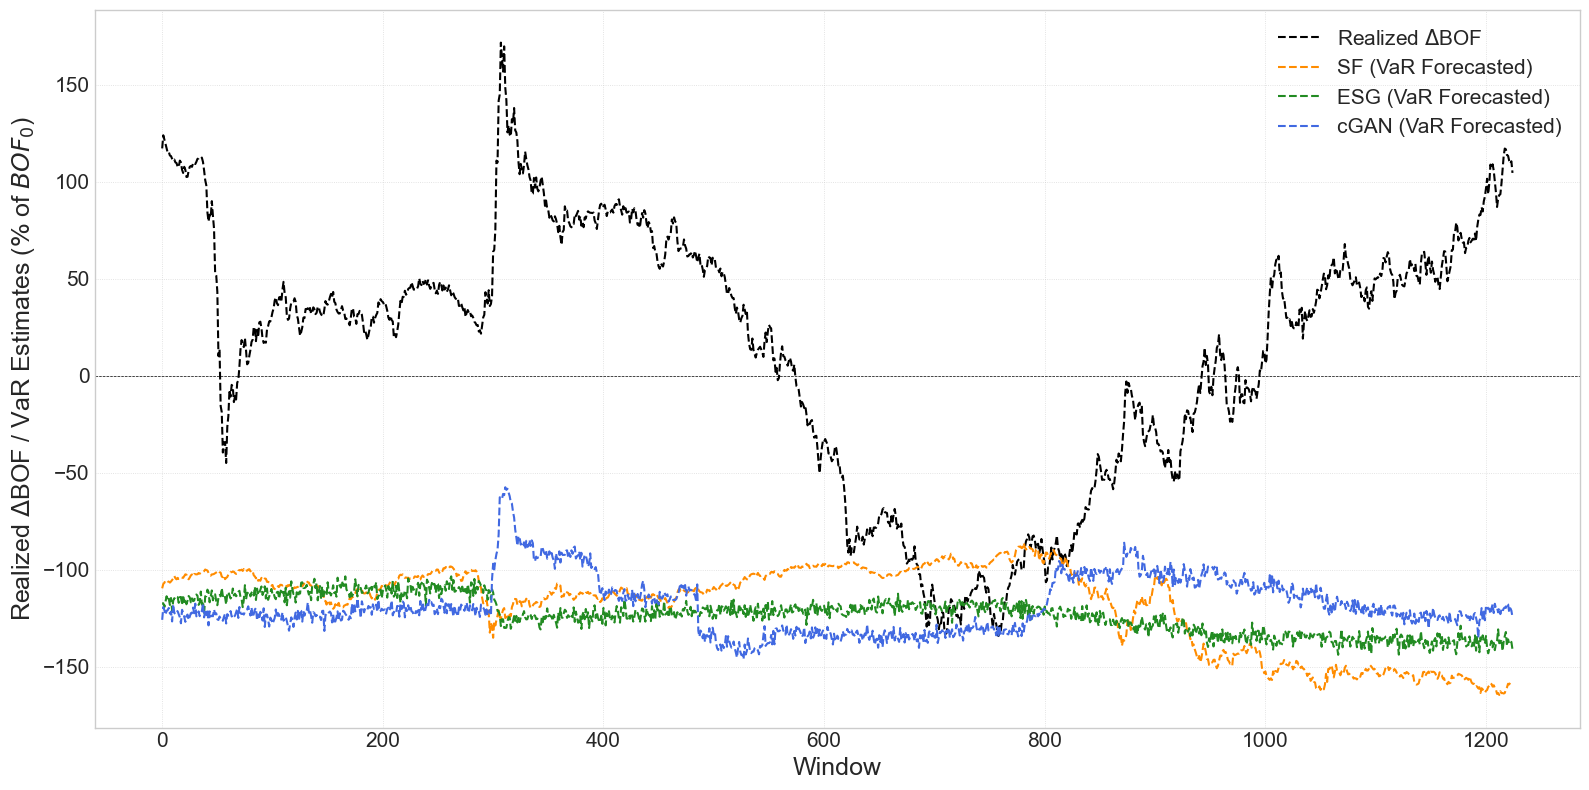

In [115]:
plot_var_comparison(plot_df)

In [116]:
import sys
sys.path.append('..')
from backtesting.perform_var_tests import evaluate_risk_metrics

In [117]:
evaluate_risk_metrics(scr_values=plot_df['SF'],  realized_delta_bof_values=plot_df['Realized Delta BOF'])

breaches [0 0 0 ... 0 0 0]


Metric      Value  \
0   Balanced SCR Loss (α=0.25)    33.7794   
1    Balanced SCR Loss (α=0.5)    67.5541   
2   Balanced SCR Loss (α=0.75)   101.3287   
3    Kupiec POF Test Statistic   418.9751   
4      Kupiec POF Test p-value     0.0000   
5        Indep. Test Statistic   621.4262   
6          Indep. Test p-value     0.0000   
7     Cond. Coverage Statistic  1040.4013   
8       Cond. Coverage p-value     0.0000   
9           Lopez Average Loss     0.0920   
10                 Breach Rate     0.0873   

                                    Description Pass/Fail  
0                Penalty for under-conservatism            
1                          Penalty for balanced            
2              Penalty for capital inefficiency            
3                         Kupiec test statistic            
4    Tests if breach frequency matches expected         ❌  
5                   Independence test statistic            
6             Tests if breaches are independent         ❌  
7           Conditional coverage test statistic            
8   Combined test of frequency and independence         ❌  
9      Quadratic loss function for VaR breaches            
10      Proportion of time when Delta BOF < SCR

In [118]:
evaluate_risk_metrics(scr_values=plot_df['ESG'],  realized_delta_bof_values=plot_df['Realized Delta BOF'])

breaches [0 0 0 ... 0 0 0]


Metric     Value  \
0   Balanced SCR Loss (α=0.25)   34.4286   
1    Balanced SCR Loss (α=0.5)   68.8571   
2   Balanced SCR Loss (α=0.75)  103.2856   
3    Kupiec POF Test Statistic   75.8067   
4      Kupiec POF Test p-value    0.0000   
5        Indep. Test Statistic  230.1452   
6          Indep. Test p-value    0.0000   
7     Cond. Coverage Statistic  305.9519   
8       Cond. Coverage p-value    0.0000   
9           Lopez Average Loss    0.0312   
10                 Breach Rate    0.0310   

                                    Description Pass/Fail  
0                Penalty for under-conservatism            
1                          Penalty for balanced            
2              Penalty for capital inefficiency            
3                         Kupiec test statistic            
4    Tests if breach frequency matches expected         ❌  
5                   Independence test statistic            
6             Tests if breaches are independent         ❌  
7           Conditional coverage test statistic            
8   Combined test of frequency and independence         ❌  
9      Quadratic loss function for VaR breaches            
10      Proportion of time when Delta BOF < SCR

In [119]:
len(plot_df['Realized Delta BOF'])

1225

In [120]:
evaluate_risk_metrics(scr_values=plot_df['CGAN'],  realized_delta_bof_values=plot_df['Realized Delta BOF'])

breaches [0 0 0 ... 0 0 0]


Metric    Value  \
0   Balanced SCR Loss (α=0.25)  33.0844   
1    Balanced SCR Loss (α=0.5)  66.1689   
2   Balanced SCR Loss (α=0.75)  99.2533   
3    Kupiec POF Test Statistic   1.9754   
4      Kupiec POF Test p-value   0.1599   
5        Indep. Test Statistic   0.0147   
6          Indep. Test p-value   0.9034   
7     Cond. Coverage Statistic   1.9901   
8       Cond. Coverage p-value   0.3697   
9           Lopez Average Loss   0.0024   
10                 Breach Rate   0.0024   

                                    Description Pass/Fail  
0                Penalty for under-conservatism            
1                          Penalty for balanced            
2              Penalty for capital inefficiency            
3                         Kupiec test statistic            
4    Tests if breach frequency matches expected         ✅  
5                   Independence test statistic            
6             Tests if breaches are independent         ✅  
7           Conditional coverage test statistic            
8   Combined test of frequency and independence         ✅  
9      Quadratic loss function for VaR breaches            
10      Proportion of time when Delta BOF < SCR

# Responsiveness to Market Conditions

In [121]:
first1yr_realized_delta_bof = pd.read_csv('First 1yr - Realized Delta BOF.csv')
first1yr_realized_delta_bof['Realized_Delta_BOF'] = (first1yr_realized_delta_bof['Realized_Delta_BOF'] / 120000) * 100
first1yr_realized_delta_bof.head()

Realized_Delta_BOF
0              -12.48
1              -17.08
2              -12.79
3               -9.96
4               -6.26

In [122]:
first1yr_realized_delta_bof.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Realized_Delta_BOF  251 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [123]:
plot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225 entries, 0 to 1224
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Window              1225 non-null   int64  
 1   SF                  1225 non-null   float64
 2   Realized Delta BOF  1225 non-null   float64
 3   ESG                 1225 non-null   float64
 4   CGAN                1225 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 48.0 KB


<>:7: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:36: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:36: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nicka\AppData\Local\Temp\ipykernel_7256\1329727827.py:7: SyntaxWarning: invalid escape sequence '\D'
  label='Realized $\Delta$BOF', color='black', linestyle='--', linewidth=1.5, alpha=1)
C:\Users\nicka\AppData\Local\Temp\ipykernel_7256\1329727827.py:18: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('Realized $\Delta$BOF / VaR Estimates ($\%$ of $BOF_0$)', fontsize=18)
C:\Users\nicka\AppData\Local\Temp\ipykernel_7256\1329727827.py:36: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(first1yr_window, first1yr_realized_delta_bof['Realized_Delta_BOF'], label='Realized $\Delta$BOF (initial 251 days)', color='grey', linestyle='--', linewidth=1.5, alpha=0.6)


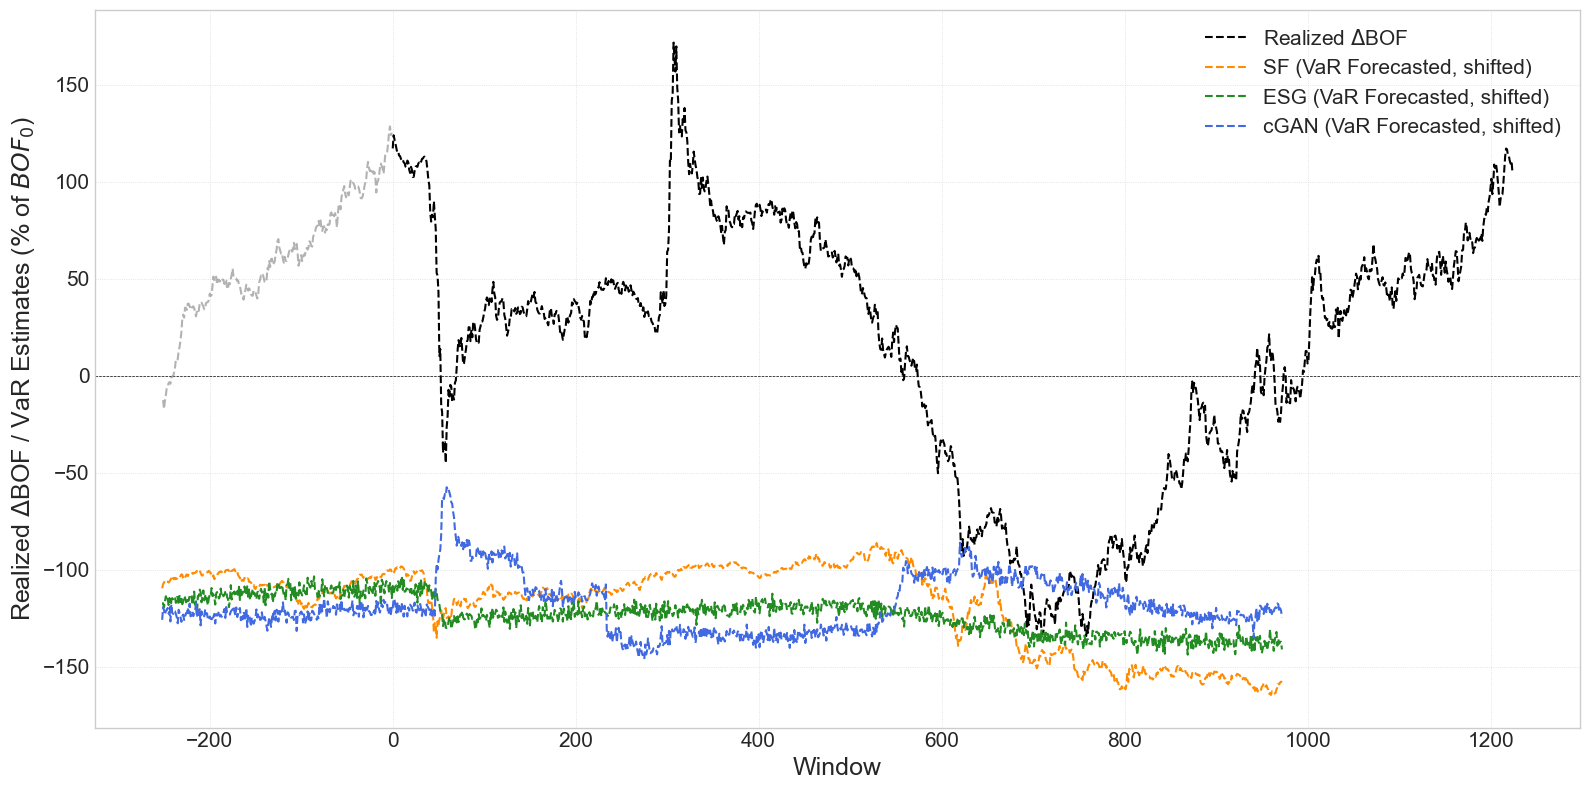

In [124]:
plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(16, 8))

# Plot Realized Delta BOF
plt.plot(plot_df['Window'], plot_df['Realized Delta BOF'],
         label='Realized $\Delta$BOF', color='black', linestyle='--', linewidth=1.5, alpha=1)

# Plot SF and ESG with both values and x shifted
plt.plot(plot_df['Window'] - 252, plot_df['SF'],
         label='SF (VaR Forecasted, shifted)', color='darkorange', linestyle='--', linewidth=1.5)
plt.plot(plot_df['Window'] - 252, plot_df['ESG'],
         label='ESG (VaR Forecasted, shifted)', color='forestgreen', linestyle='--', linewidth=1.5)
plt.plot(plot_df['Window'] - 252, plot_df['CGAN'],
         label='cGAN (VaR Forecasted, shifted)', color='royalblue', linestyle='--', linewidth=1.5)

plt.xlabel('Window', fontsize=18)
plt.ylabel('Realized $\Delta$BOF / VaR Estimates ($\%$ of $BOF_0$)', fontsize=18)

legend = plt.legend(fontsize=15, frameon=False, fancybox=True,
                    shadow=True, framealpha=0.95, loc='best')
legend.get_frame().set_edgecolor('black')

plt.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
plt.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

plt.tight_layout()

first1yr_window = list(range(-251, 0))  

plt.plot(first1yr_window, first1yr_realized_delta_bof['Realized_Delta_BOF'], label='Realized $\Delta$BOF (initial 251 days)', color='grey', linestyle='--', linewidth=1.5, alpha=0.6)


plt.show()

First date in grey : 2019-01-01

Last date in grey : 2019-12-31 

First date in black : 2020-01-02

# Average Required Capital 

In [125]:
cum_df = plot_df.filter(items=['Window', 'SF', 'ESG', 'CGAN']).copy()
cum_df['SF'] = (cum_df['SF'] * -1)
cum_df['ESG'] = (cum_df['ESG'] * -1)
cum_df['CGAN'] = (cum_df['CGAN'] * -1)
cum_df.head()

Window     SF    ESG   CGAN
0       0 109.49 117.24 125.73
1       1 107.22 117.19 119.18
2       2 106.63 119.20 120.75
3       3 105.38 116.32 123.14
4       4 105.45 113.57 120.99

<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\%'
C:\Users\nicka\AppData\Local\Temp\ipykernel_7256\3654640451.py:14: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel('SCR ($\%$ of $BOF_0$})', fontsize=18)


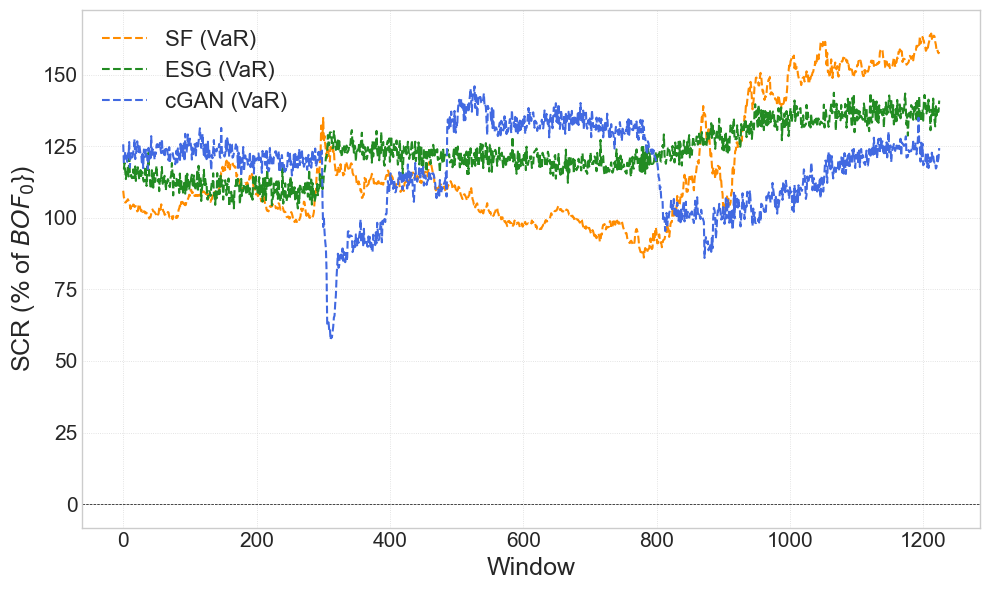

In [126]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))


plt.plot(cum_df['Window'], cum_df['SF'], label='SF (VaR)', color='darkorange',
         linestyle='--', linewidth=1.5, marker=None, markersize=3)
plt.plot(cum_df['Window'], cum_df['ESG'], label='ESG (VaR)',
         color='forestgreen', linestyle='--', linewidth=1.5, marker=None, markersize=3)
plt.plot(cum_df['Window'], cum_df['CGAN'], label='cGAN (VaR)',
         color='royalblue', linestyle='--', linewidth=1.5, marker=None, markersize=3)


plt.xlabel('Window', fontsize=18)
plt.ylabel('SCR ($\%$ of $BOF_0$})', fontsize=18)

legend = plt.legend(fontsize=16, frameon=False, fancybox=True,
                    shadow=True, framealpha=0.95, loc='best')
legend.get_frame().set_edgecolor('black')

plt.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
plt.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')


plt.tight_layout()

plt.show()

## Integral under plots - Just for fun

In [127]:
import numpy as np

# Calculate area under each curve
sf_integral = np.trapz(cum_df['SF'], cum_df['Window'])
esg_integral = np.trapz(cum_df['ESG'], cum_df['Window'])
cgan_integral = np.trapz(cum_df['CGAN'], cum_df['Window'])

print(f"SF (VaR) integral: {sf_integral:.4f}")
print(f"ESG (VaR) integral: {esg_integral:.4f}")
print(f"cGAN (VaR) integral: {cgan_integral:.4f}")

SF (VaR) integral: 143730.6384
ESG (VaR) integral: 150318.3477
cGAN (VaR) integral: 144322.4721


C:\Users\nicka\AppData\Local\Temp\ipykernel_7256\2511408556.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  sf_integral = np.trapz(cum_df['SF'], cum_df['Window'])
C:\Users\nicka\AppData\Local\Temp\ipykernel_7256\2511408556.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  esg_integral = np.trapz(cum_df['ESG'], cum_df['Window'])
C:\Users\nicka\AppData\Local\Temp\ipykernel_7256\2511408556.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cgan_integral = np.trapz(cum_df['CGAN'], cum_df['Window'])


In [128]:
cum_df.describe()

Window       SF      ESG     CGAN
count 1,225.00 1,225.00 1,225.00 1,225.00
mean    612.00   117.44   122.81   117.92
std     353.77    21.29     9.22    14.35
min       0.00    86.14   103.31    57.40
25%     306.00   101.54   116.17   109.21
50%     612.00   110.01   121.91   120.99
75%     918.00   130.99   129.99   127.76
max   1,224.00   164.45   143.75   146.00

<>:13: SyntaxWarning: invalid escape sequence '\%'
<>:28: SyntaxWarning: invalid escape sequence '\%'
<>:43: SyntaxWarning: invalid escape sequence '\%'
<>:13: SyntaxWarning: invalid escape sequence '\%'
<>:28: SyntaxWarning: invalid escape sequence '\%'
<>:43: SyntaxWarning: invalid escape sequence '\%'
C:\Users\nicka\AppData\Local\Temp\ipykernel_7256\4281805509.py:13: SyntaxWarning: invalid escape sequence '\%'
  ax1.set_xlabel('SCR ($\%$ of $BOF_0$)', fontsize=16)
C:\Users\nicka\AppData\Local\Temp\ipykernel_7256\4281805509.py:28: SyntaxWarning: invalid escape sequence '\%'
  ax2.set_xlabel('SCR ($\%$ of $BOF_0$)', fontsize=16)
C:\Users\nicka\AppData\Local\Temp\ipykernel_7256\4281805509.py:43: SyntaxWarning: invalid escape sequence '\%'
  ax3.set_xlabel('SCR ($\%$ of $BOF_0$)', fontsize=16)


Area under SF distribution: 2940.00


C:\Users\nicka\AppData\Local\Temp\ipykernel_7256\4281805509.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(counts, bin_centers)


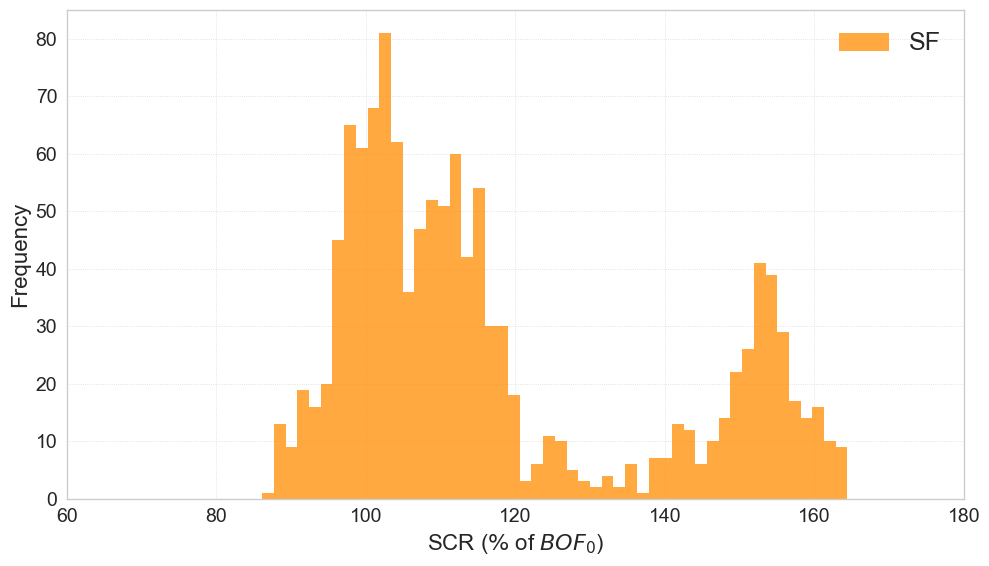

Area under ESG distribution: 2940.00


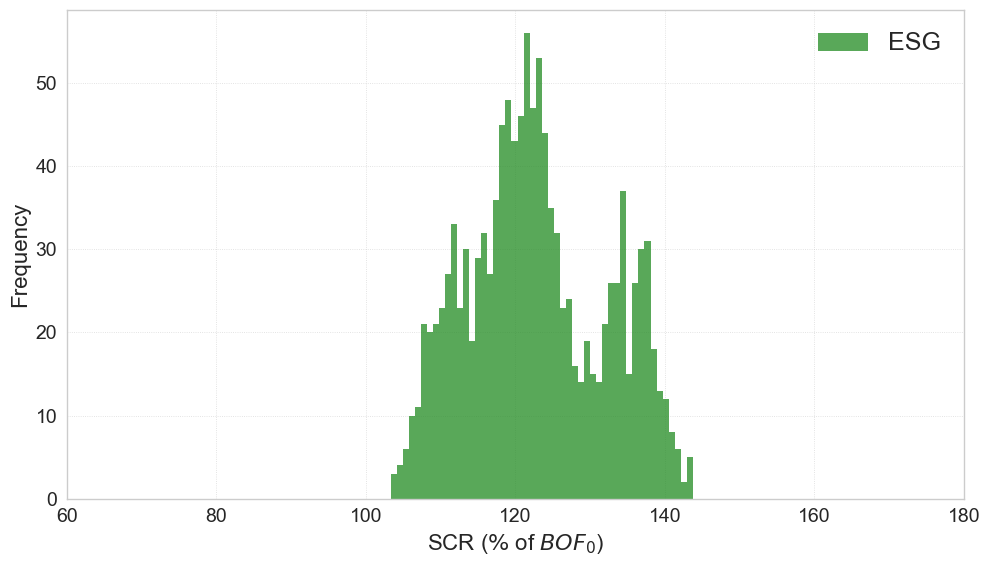

Area under CGAN distribution: 2928.00


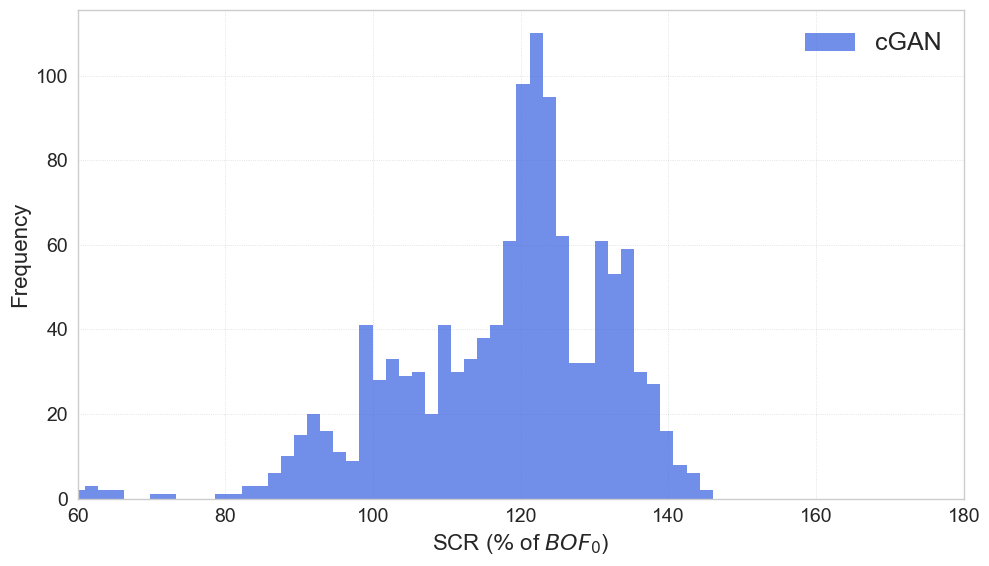

SF area: 2940.00
ESG area: 2940.00
CGAN area: 2928.00


In [129]:
plt.style.use('seaborn-v0_8-whitegrid')

def calculate_area_under_histogram(data, bins=50, x_range=(60, 180)):
    counts, bin_edges = np.histogram(data, bins=bins, range=x_range)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    area = np.trapz(counts, bin_centers)
    return area, counts, bin_centers

fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.hist(cum_df['SF'], bins=50, color='darkorange', edgecolor=None, alpha=0.75, label='SF')
sf_area, sf_counts, sf_centers = calculate_area_under_histogram(cum_df['SF'])
print(f"Area under SF distribution: {sf_area:.2f}")
ax1.set_xlabel('SCR ($\%$ of $BOF_0$)', fontsize=16)
ax1.set_ylabel('Frequency', fontsize=16)
ax1.set_xlim(60, 180)
legend1 = ax1.legend(fontsize=18, frameon=False, fancybox=True, shadow=True, framealpha=0.95, loc='best')
legend1.get_frame().set_edgecolor('black')
ax1.tick_params(axis='both', which='major', labelsize=14, pad=7)
ax1.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
ax1.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5, axis='y')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.hist(cum_df['ESG'], bins=50, color='forestgreen', edgecolor=None, alpha=0.75, label='ESG')
esg_area, esg_counts, esg_centers = calculate_area_under_histogram(cum_df['ESG'])
print(f"Area under ESG distribution: {esg_area:.2f}")
ax2.set_xlabel('SCR ($\%$ of $BOF_0$)', fontsize=16)
ax2.set_ylabel('Frequency', fontsize=16)
ax2.set_xlim(60, 180)
legend2 = ax2.legend(fontsize=18, frameon=False, fancybox=True, shadow=True, framealpha=0.95, loc='best')
legend2.get_frame().set_edgecolor('black')
ax2.tick_params(axis='both', which='major', labelsize=14, pad=7)
ax2.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
ax2.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5, axis='y')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

fig3, ax3 = plt.subplots(figsize=(10, 6))
ax3.hist(cum_df['CGAN'], bins=50, color='royalblue', edgecolor=None, alpha=0.75, label='cGAN')
cgan_area, cgan_counts, cgan_centers = calculate_area_under_histogram(cum_df['CGAN'])
print(f"Area under CGAN distribution: {cgan_area:.2f}")
ax3.set_xlabel('SCR ($\%$ of $BOF_0$)', fontsize=16)
ax3.set_ylabel('Frequency', fontsize=16)
ax3.set_xlim(60, 180)
legend3 = ax3.legend(fontsize=18, frameon=False, fancybox=True, shadow=True, framealpha=0.95, loc='best')
legend3.get_frame().set_edgecolor('black')
ax3.tick_params(axis='both', which='major', labelsize=14, pad=7)
ax3.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
ax3.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5, axis='y')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print(f"SF area: {sf_area:.2f}")
print(f"ESG area: {esg_area:.2f}")
print(f"CGAN area: {cgan_area:.2f}")

<>:12: SyntaxWarning: invalid escape sequence '\%'
<>:12: SyntaxWarning: invalid escape sequence '\%'
C:\Users\nicka\AppData\Local\Temp\ipykernel_7256\2794376090.py:12: SyntaxWarning: invalid escape sequence '\%'
  ax.set_xlabel('SCR ($\%$ of $BOF_0$)', fontsize=16, labelpad=10)


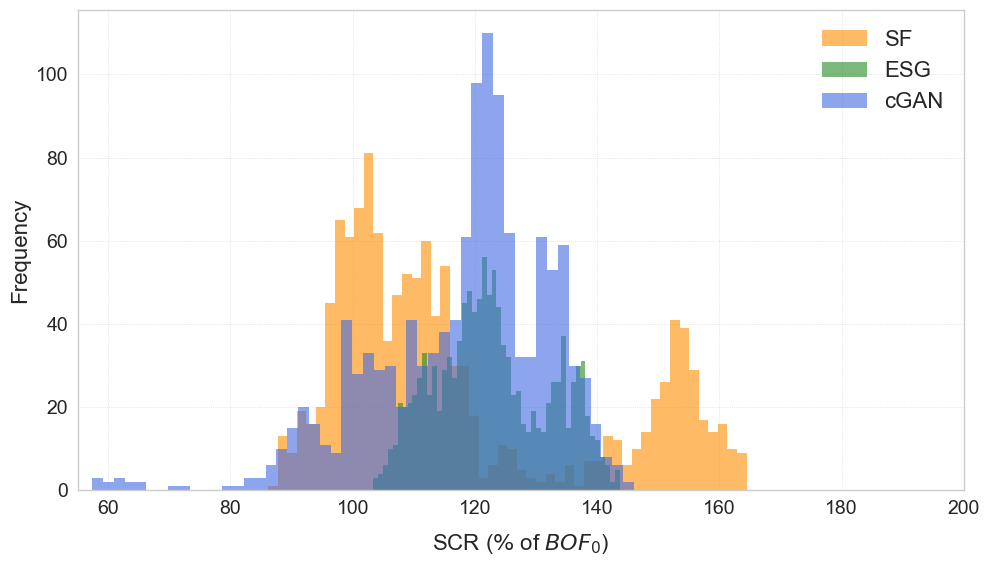

In [130]:
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(cum_df['SF'], bins=50, color='darkorange',
        alpha=0.6, label='SF', edgecolor=None)
ax.hist(cum_df['ESG'], bins=50, color='forestgreen',
        alpha=0.6, label='ESG', edgecolor=None)
ax.hist(cum_df['CGAN'], bins=50, color='royalblue',
        alpha=0.6, label='cGAN', edgecolor=None)

ax.set_xlabel('SCR ($\%$ of $BOF_0$)', fontsize=16, labelpad=10)
ax.set_ylabel('Frequency', fontsize=16)

ax.set_xlim(55, 200)

legend = ax.legend(fontsize=16, frameon=False, fancybox=True,
                   shadow=True, framealpha=0.95, loc='best')
legend.get_frame().set_edgecolor('black')

ax.tick_params(axis='both', which='major', labelsize=14, pad=7)

ax.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
ax.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5, axis='y')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [131]:
sf_count = len(cum_df['SF'].dropna())
esg_count = len(cum_df['ESG'].dropna())
cgan_count = len(cum_df['CGAN'].dropna())

print("Sample sizes:")
print(f"SF:   {sf_count:,}")
print(f"ESG:  {esg_count:,}")
print(f"cGAN: {cgan_count:,}")

# Check if any are different
if len(set([sf_count, esg_count, cgan_count])) > 1:
    print("\n⚠️  Sample sizes are NOT equal!")
    max_count = max(sf_count, esg_count, cgan_count)
    min_count = min(sf_count, esg_count, cgan_count)
    print(f"Difference: {max_count - min_count:,} samples")
else:
    print("\n✓ All sample sizes are equal")

# Check for missing values
print(f"\nMissing values:")
print(f"SF:   {cum_df['SF'].isna().sum()}")
print(f"ESG:  {cum_df['ESG'].isna().sum()}")
print(f"cGAN: {cum_df['CGAN'].isna().sum()}")

# Check data range coverage within your plot limits (60-180)
sf_in_range = ((cum_df['SF'] >= 60) & (cum_df['SF'] <= 180)).sum()
esg_in_range = ((cum_df['ESG'] >= 60) & (cum_df['ESG'] <= 180)).sum()
cgan_in_range = ((cum_df['CGAN'] >= 60) & (cum_df['CGAN'] <= 180)).sum()

print(f"\nData points within plot range (60-180):")
print(f"SF:   {sf_in_range:,}")
print(f"ESG:  {esg_in_range:,}")
print(f"cGAN: {cgan_in_range:,}")

Sample sizes:
SF:   1,225
ESG:  1,225
cGAN: 1,225

✓ All sample sizes are equal

Missing values:
SF:   0
ESG:  0
cGAN: 0

Data points within plot range (60-180):
SF:   1,225
ESG:  1,225
cGAN: 1,222


# VaR testing \ capital efficiency per GAN-type

In [132]:
asset_classes = pd.read_csv('../data/final_asset_classes.csv', index_col=0, parse_dates=True)
asset_classes.columns = ['RE', 'PE', 'EQ', 'IG CB', 'GB', 'HY CB', 'Money']
asset_classes = asset_classes[['EQ', 'PE','RE', 'IG CB', 'HY CB', 'GB', 'Money']]
asset_classes.head()

EQ   PE   RE  IG CB  HY CB   GB  Money
Date                                               
2005-10-10 1.00 1.00 1.00   1.00   1.00 1.00   1.00
2005-10-11 1.00 1.01 1.00   1.00   1.00 1.00   1.00
2005-10-12 1.00 1.00 1.00   1.00   0.99 1.00   1.00
2005-10-13 1.00 0.99 0.98   0.99   0.99 0.99   1.00
2005-10-14 0.99 0.99 0.97   0.99   0.99 0.99   1.00

In [133]:
asset_classes.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4891 entries, 2005-10-10 to 2024-11-13
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EQ      4890 non-null   float64
 1   PE      4874 non-null   float64
 2   RE      4870 non-null   float64
 3   IG CB   4810 non-null   float64
 4   HY CB   4810 non-null   float64
 5   GB      4879 non-null   float64
 6   Money   4891 non-null   float64
dtypes: float64(7)
memory usage: 305.7 KB


<>:25: SyntaxWarning: invalid escape sequence '\D'
<>:31: SyntaxWarning: invalid escape sequence '\D'
<>:35: SyntaxWarning: invalid escape sequence '\D'
<>:25: SyntaxWarning: invalid escape sequence '\D'
<>:31: SyntaxWarning: invalid escape sequence '\D'
<>:35: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nicka\AppData\Local\Temp\ipykernel_7256\806828781.py:25: SyntaxWarning: invalid escape sequence '\D'
  ax1.plot(plot_df['Window'], plot_df['Realized Delta BOF'], label='Realized $\Delta$BOF', color='black', linestyle='--', linewidth=1.5)
C:\Users\nicka\AppData\Local\Temp\ipykernel_7256\806828781.py:31: SyntaxWarning: invalid escape sequence '\D'
  ax1.plot(range(-251, 0), first1yr_realized_delta_bof['Realized_Delta_BOF'], label='Realized $\Delta$BOF (initial 251 days)', color='grey', linestyle='--', linewidth=1.5)
C:\Users\nicka\AppData\Local\Temp\ipykernel_7256\806828781.py:35: SyntaxWarning: invalid escape sequence '\D'
  ax1.set_ylabel('Realized $\Delta$BOF / VaR Estimates 

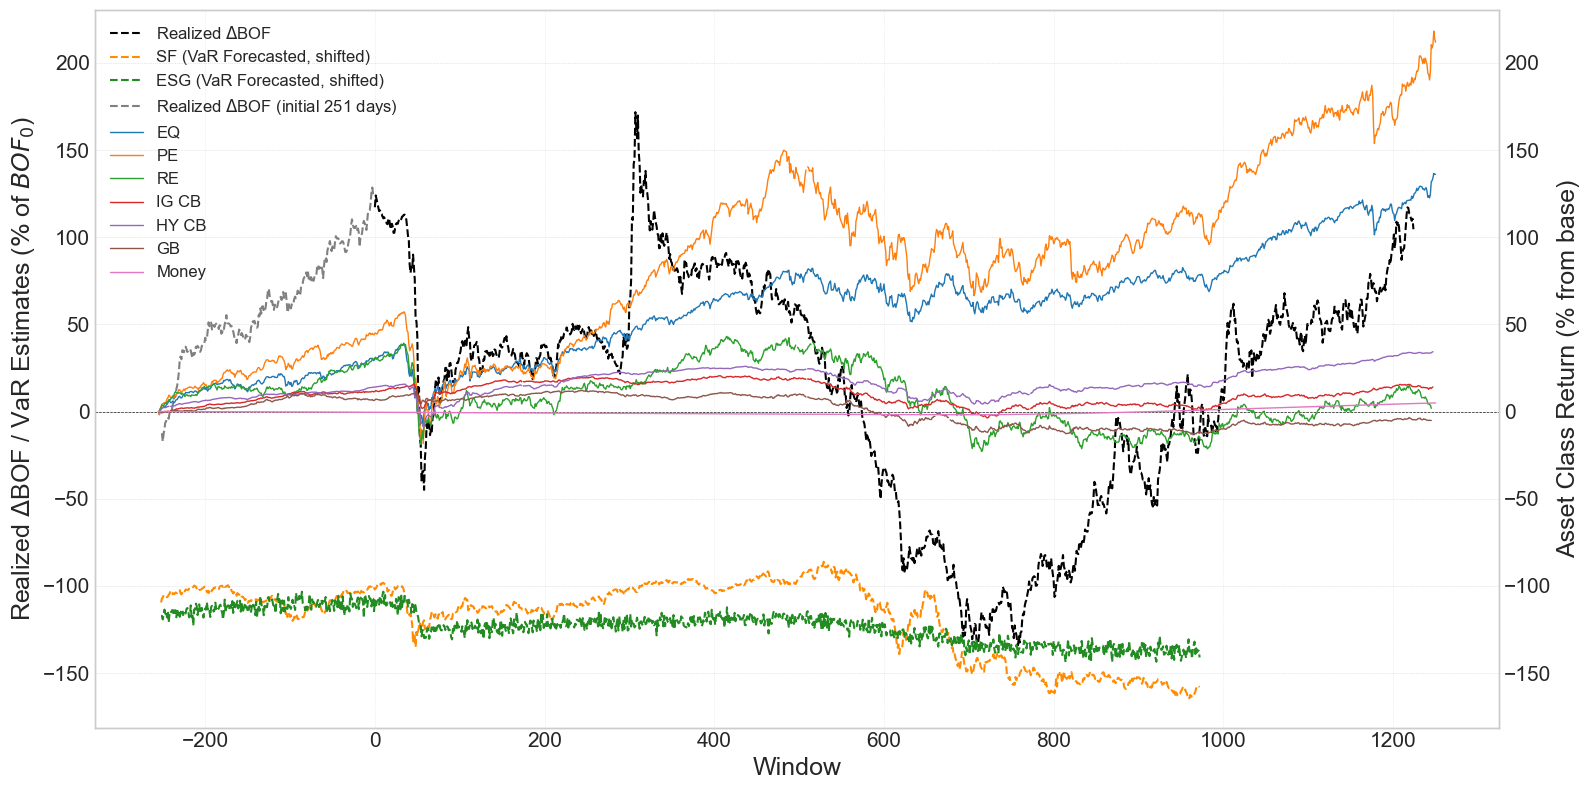

In [134]:
first1yr_start_date = pd.to_datetime('2019-01-01')
first1yr_end_date = pd.to_datetime('2019-12-31')
main_bof_start_date = pd.to_datetime('2020-01-02')
main_bof_end_date = pd.to_datetime('2024-11-13')

first1yr_slice = asset_classes.loc[first1yr_start_date:first1yr_end_date].copy()
main_bof_slice = asset_classes.loc[main_bof_start_date:main_bof_end_date].copy()

first1yr_slice['Window'] = range(-len(first1yr_slice), 0)
main_bof_slice['Window'] = range(0, len(main_bof_slice))
asset_window_df = pd.concat([first1yr_slice, main_bof_slice])

asset_pct = asset_window_df.drop(columns='Window').div(
    asset_window_df.drop(columns='Window').iloc[0]).subtract(1).multiply(100)


asset_pct['Window'] = asset_window_df['Window'].values


plt.style.use('seaborn-v0_8-whitegrid')

fig, ax1 = plt.subplots(figsize=(16, 8))


ax1.plot(plot_df['Window'], plot_df['Realized Delta BOF'], label='Realized $\Delta$BOF', color='black', linestyle='--', linewidth=1.5)

ax1.plot(plot_df['Window'] - 252, plot_df['SF'], label='SF (VaR Forecasted, shifted)', color='darkorange', linestyle='--', linewidth=1.5)

ax1.plot(plot_df['Window'] - 252, plot_df['ESG'], label='ESG (VaR Forecasted, shifted)', color='forestgreen', linestyle='--', linewidth=1.5)

ax1.plot(range(-251, 0), first1yr_realized_delta_bof['Realized_Delta_BOF'], label='Realized $\Delta$BOF (initial 251 days)', color='grey', linestyle='--', linewidth=1.5)

ax1.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax1.set_xlabel('Window', fontsize=18)
ax1.set_ylabel('Realized $\Delta$BOF / VaR Estimates ($\%$ of $BOF_0$)', fontsize=18)
ax1.tick_params(axis='both', labelsize=15)


ax2 = ax1.twinx()

for col in ['EQ', 'PE', 'RE', 'IG CB', 'HY CB', 'GB', 'Money']:
    ax2.plot(asset_pct['Window'], asset_pct[col], label=col, linewidth=1)

ax2.set_ylabel('Asset Class Return (% from base)', fontsize=18)
ax2.tick_params(axis='y', labelsize=15)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=12, loc='upper left',frameon=False, fancybox=True, shadow=True, framealpha=0.95)


y1_min, y1_max = ax1.get_ylim()
y2_min, y2_max = ax2.get_ylim()

y1_range_below = abs(y1_min)
y1_range_above = abs(y1_max)
y2_range_below = abs(y2_min)
y2_range_above = abs(y2_max)

below = max(y1_range_below, y2_range_below)
above = max(y1_range_above, y2_range_above)

ax1.set_ylim(-below, above)
ax2.set_ylim(-below, above)
ax1.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.5)
ax2.grid(True, which='major', linestyle=':', linewidth=0.4, alpha=0.5)


plt.tight_layout()
plt.show()

# Plotting Forecasted vs realised VaR for all assets 

### dealing with a gay data format

In [135]:
def _fully_flatten_cell_content(content) -> list:
    if isinstance(content, str):
        tensor_match = re.match(r"tensor\(([^,]+),.*\)", content)
        if tensor_match:
            try:
                numeric_value = float(tensor_match.group(1))
                return [numeric_value]
            except (ValueError, TypeError):
                pass

        try:
            evaluated_content = ast.literal_eval(content)
            if evaluated_content == content and not tensor_match:
                return [content]
            return _fully_flatten_cell_content(evaluated_content)
        except (ValueError, SyntaxError):
            return [content]
    elif isinstance(content, (list, tuple)):
        items = []
        for item in content:
            items.extend(_fully_flatten_cell_content(item))
        return items
    else:
        return [content]


def unpack_and_explode_column(df: pd.DataFrame, column_to_unpack: str) -> pd.DataFrame:
    if column_to_unpack not in df.columns:
        raise ValueError(
            f"DataFrame must contain a '{column_to_unpack}' column.")

    processed_series = df[column_to_unpack].apply(_fully_flatten_cell_content)

    new_df = df.copy()

    new_df[column_to_unpack] = processed_series

    return new_df.explode(column_to_unpack)

In [136]:
def plot_single_forecast(df, window_col, realized_col, var_col, label='VaR Forecast', bounds = None):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(14, 6))

    plt.plot(df[window_col], df[realized_col], label='Realized Return',
             color='black', linestyle='--', linewidth=1.5)
    plt.plot(df[window_col], df[var_col], label=label,
             color='forestgreen', linestyle='--', linewidth=1.5)

    plt.xlabel('Window', fontsize=18)
    plt.ylabel(
        'Realized Return / VaR Estimate ($\%$)', fontsize=18)
    
    if not bounds:
        plt.ylim(-70, 110)
    else:
        plt.ylim(bounds[0], bounds[1])

    legend = plt.legend(fontsize=18, frameon=False, fancybox=True,
                        shadow=True, framealpha=0.95, loc='best')
    legend.get_frame().set_edgecolor('black')

    plt.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
    plt.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

    plt.tight_layout()
    plt.show()

<>:12: SyntaxWarning: invalid escape sequence '\%'
<>:12: SyntaxWarning: invalid escape sequence '\%'
C:\Users\nicka\AppData\Local\Temp\ipykernel_7256\3208810118.py:12: SyntaxWarning: invalid escape sequence '\%'
  'Realized Return / VaR Estimate ($\%$)', fontsize=18)


### EQ

In [137]:
eq.head()

Window EQ VaR (utcome-aligned)  Realised Return
0       0                  -30.21            30.64
1       1                  -31.17            34.32
2       2                  -31.32            30.64
3       3                  -29.75            29.97
4       4                  -30.34            29.11

In [138]:
eq = pd.read_csv('eq_2.csv')
pd.set_option('display.float_format', '{:,.2f}'.format)
eq = unpack_and_explode_column(eq, 'SCR')
eq.rename(columns={'SCR': 'EQ VaR (utcome-aligned)'}, inplace=True)
eq.rename(columns={'Realized_Delta_BOF': 'Realised Return'}, inplace=True)
eq = eq.reset_index().rename(columns={'index': 'Window'})
eq['EQ VaR (utcome-aligned)'] = ((eq['EQ VaR (utcome-aligned)'] - 1000000) / 1000000) * 100
eq['Realised Return'] = ((eq['Realised Return'] - 1000000) / 1000000) * 100
eq.head()

eq_esg = pd.read_csv('MSCIWORLD_esg.csv')
pd.set_option('display.float_format', '{:,.2f}'.format)
eq_esg.rename(columns={'values': 'EQ VaR (utcome-aligned)'}, inplace=True)
eq_esg['Realised Return'] = eq['Realised Return']
eq_esg['Window'] = eq['Window']
eq_esg['EQ VaR (utcome-aligned)'] = ((eq_esg['EQ VaR (utcome-aligned)'] - 1000000) / 1000000) * 100
eq_esg.head()

EQ VaR (utcome-aligned)  Realised Return  Window
0                   -36.36            30.64       0
1                   -35.70            34.32       1
2                   -36.27            30.64       2
3                   -37.51            29.97       3
4                   -35.26            29.11       4

In [139]:
def plot_shifted(shifted, df1, df2, name, col, bounds=None):
    plt.style.use('seaborn-v0_8-whitegrid')

    plt.figure(figsize=(14, 6))

    # Plot Realized Delta BOF
    plt.plot(df1['Window'], df1['Realised Return'],
            label='Realized $\Delta$BOF', color='black', linestyle='--', linewidth=1.5, alpha=1)

    # Plot SF and ESG with both values and x shifted
    plt.plot(df2['Window'] - 252, df2[col],
            label=f'{name} (VaR Forecasted, shifted)', color='forestgreen', linestyle='--', linewidth=1.5)
    plt.xlabel('Window', fontsize=18)
    plt.ylabel('Realized $\Delta$BOF / VaR Estimates ($\%$ of $BOF_0$)', fontsize=18)

    legend = plt.legend(fontsize=18, frameon=False, fancybox=True,
                        shadow=True, framealpha=0.95, loc='best')
    legend.get_frame().set_edgecolor('black')

    plt.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
    plt.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)

    if not bounds:
        plt.ylim(-70, 110)
    else:
        plt.ylim(bounds[0], bounds[1])

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

    plt.tight_layout()

    first1yr_window = list(range(-252, 0))  

    plt.plot(first1yr_window, shifted, label='Realized $\Delta$BOF (initial 251 days)', color='grey', linestyle='--', linewidth=1.5, alpha=0.6)


    plt.show()

<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:37: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:37: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nicka\AppData\Local\Temp\ipykernel_7256\1011862325.py:8: SyntaxWarning: invalid escape sequence '\D'
  label='Realized $\Delta$BOF', color='black', linestyle='--', linewidth=1.5, alpha=1)
C:\Users\nicka\AppData\Local\Temp\ipykernel_7256\1011862325.py:14: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('Realized $\Delta$BOF / VaR Estimates ($\%$ of $BOF_0$)', fontsize=18)
C:\Users\nicka\AppData\Local\Temp\ipykernel_7256\1011862325.py:37: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(first1yr_window, shifted, label='Realized $\Delta$BOF (initial 251 days)', color='grey', linestyle='--', linewidth=1.5, alpha=0.6)


In [140]:
shifted = pd.read_csv('shifted_part_all_assets.csv')
shifted.head()
shifted = ((shifted - 1000000) / 1000000) * 100
#shifted.head()

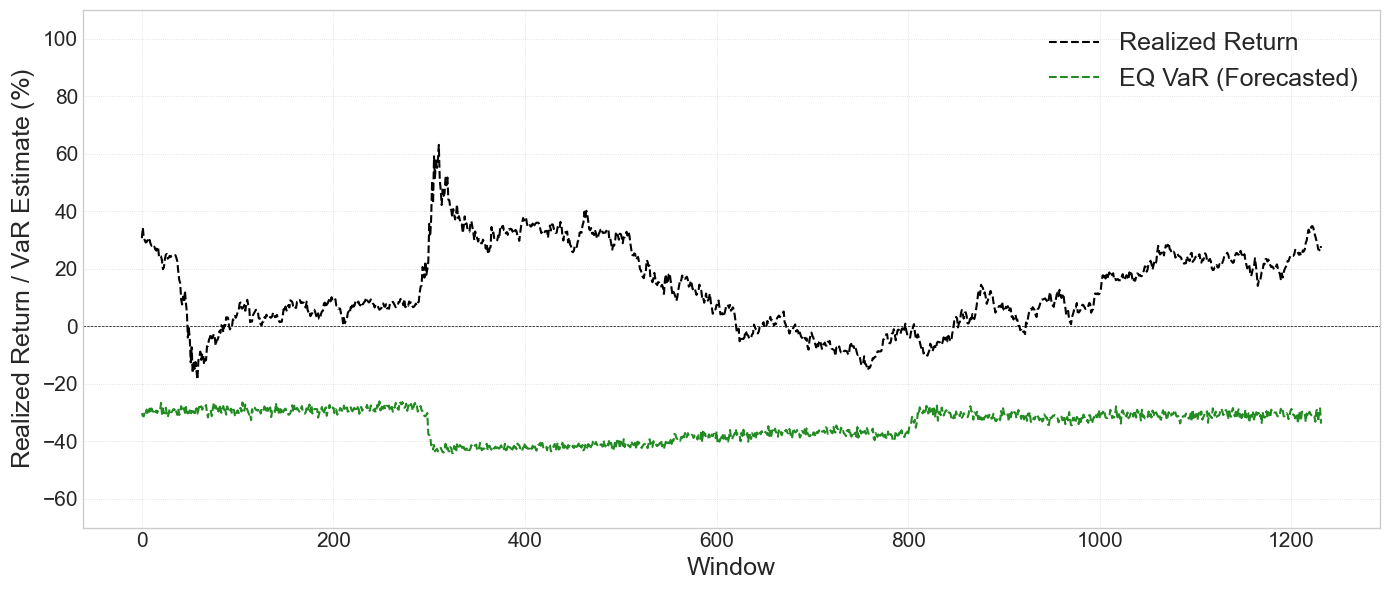

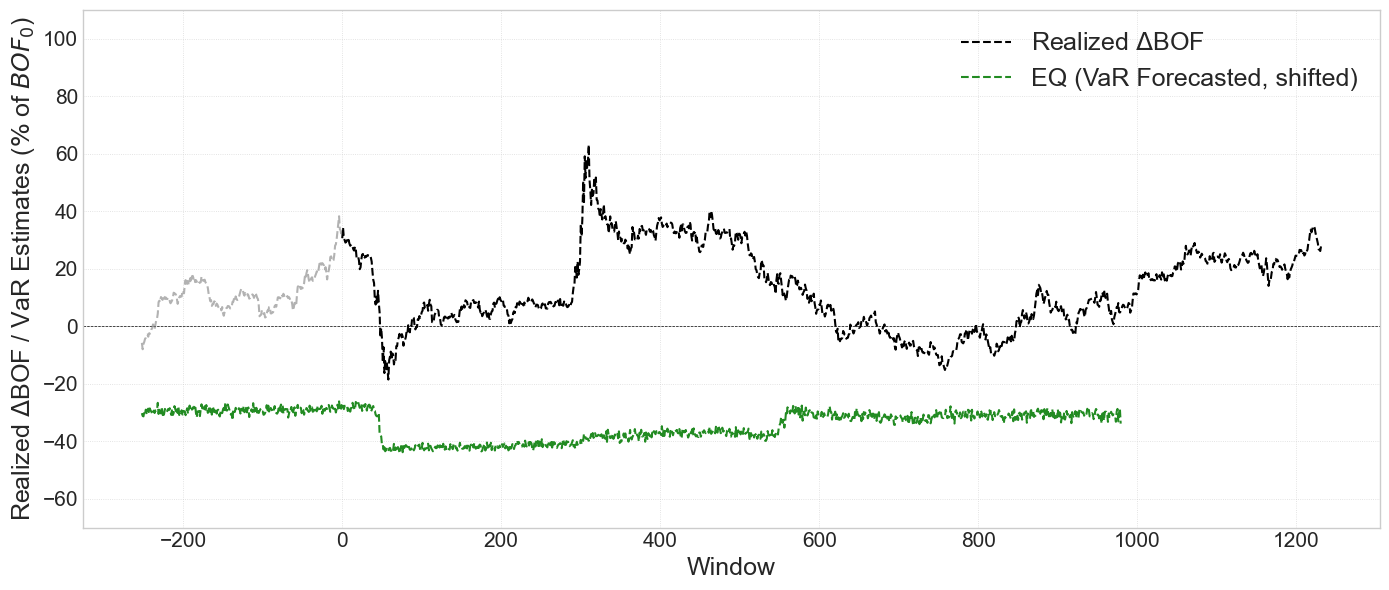

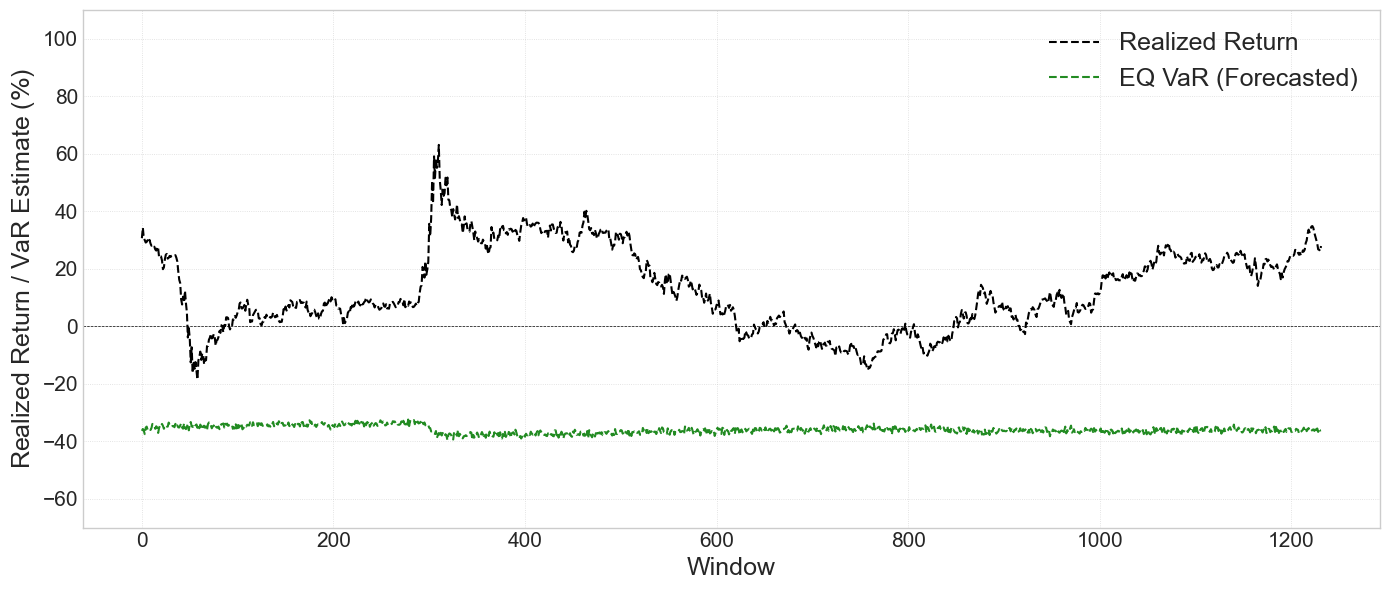

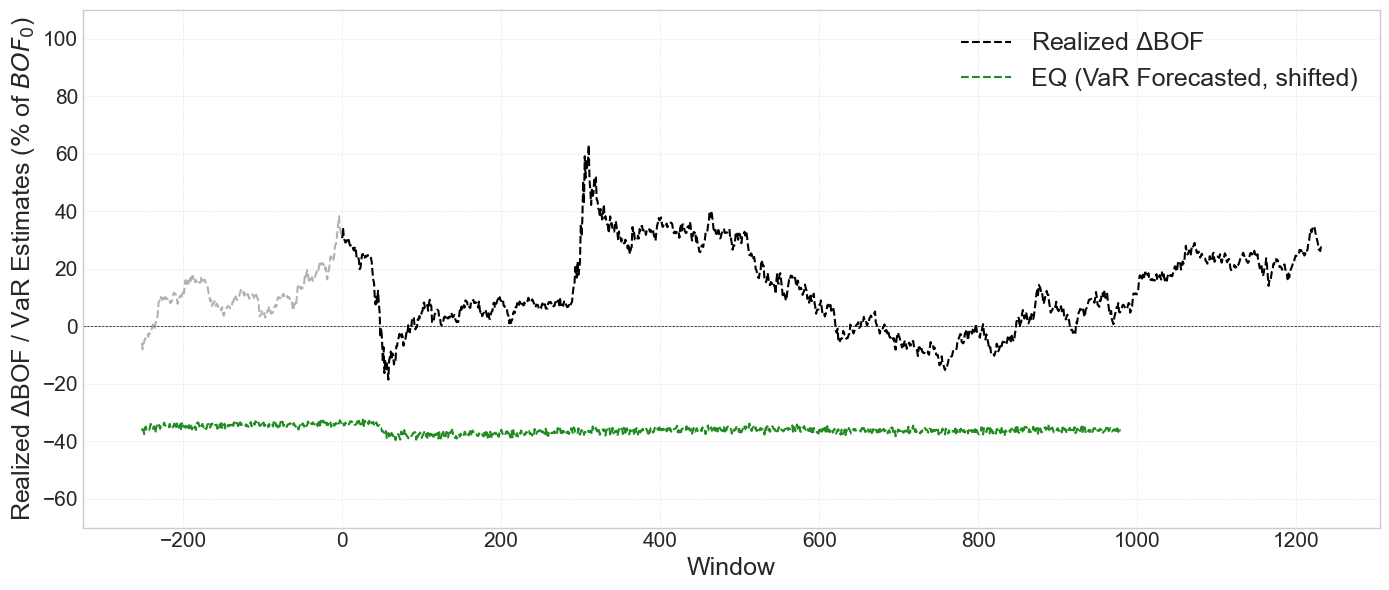

In [141]:
plot_single_forecast(
    df=eq,
    window_col='Window',
    realized_col='Realised Return',
    var_col='EQ VaR (utcome-aligned)',  
    label='EQ VaR (Forecasted)'         
)

plot_shifted(
    shifted['EQ'],
    df1=eq,
    df2=eq,
    name='EQ',
    col='EQ VaR (utcome-aligned)',  
)

plot_single_forecast(
    df=eq_esg,
    window_col='Window',
    realized_col='Realised Return',
    var_col='EQ VaR (utcome-aligned)',  
    label='EQ VaR (Forecasted)'         
)

plot_shifted(
    shifted['EQ'],
    df1=eq_esg,
    df2=eq_esg,
    name='EQ',
    col='EQ VaR (utcome-aligned)',  
)

### PE

In [142]:
pe = pd.read_csv('PE.csv')
pd.set_option('display.float_format', '{:,.2f}'.format)
pe = unpack_and_explode_column(pe, 'SCR')
pe.rename(columns={'SCR': 'PE VaR (utcome-aligned)'}, inplace=True)
pe.rename(columns={'Realized_Delta_BOF': 'Realised Return'}, inplace=True)
pe = pe.reset_index().rename(columns={'index': 'Window'})
pe['PE VaR (utcome-aligned)'] = ((pe['PE VaR (utcome-aligned)'] - 1000000) / 1000000) * 100
pe['Realised Return'] = ((pe['Realised Return'] - 1000000) / 1000000) * 100
pe.head()

pe_esg = pd.read_csv('PE_esg.csv')
pd.set_option('display.float_format', '{:,.2f}'.format)
pe_esg.rename(columns={'values': 'PE VaR (utcome-aligned)'}, inplace=True)
pe_esg['Realised Return'] = pe['Realised Return']
pe_esg['Window'] = pe['Window']
print(pe_esg.columns)
pe_esg['PE VaR (utcome-aligned)'] = ((pe_esg['PE VaR (utcome-aligned)'] - 1000000) / 1000000) * 100
pe_esg.head()

Index(['PE VaR (utcome-aligned)', 'Realised Return', 'Window'], dtype='object')


PE VaR (utcome-aligned)  Realised Return  Window
0                   -47.14            45.66       0
1                   -46.27            49.12       1
2                   -45.57            44.76       2
3                   -45.82            41.95       3
4                   -45.57            40.61       4

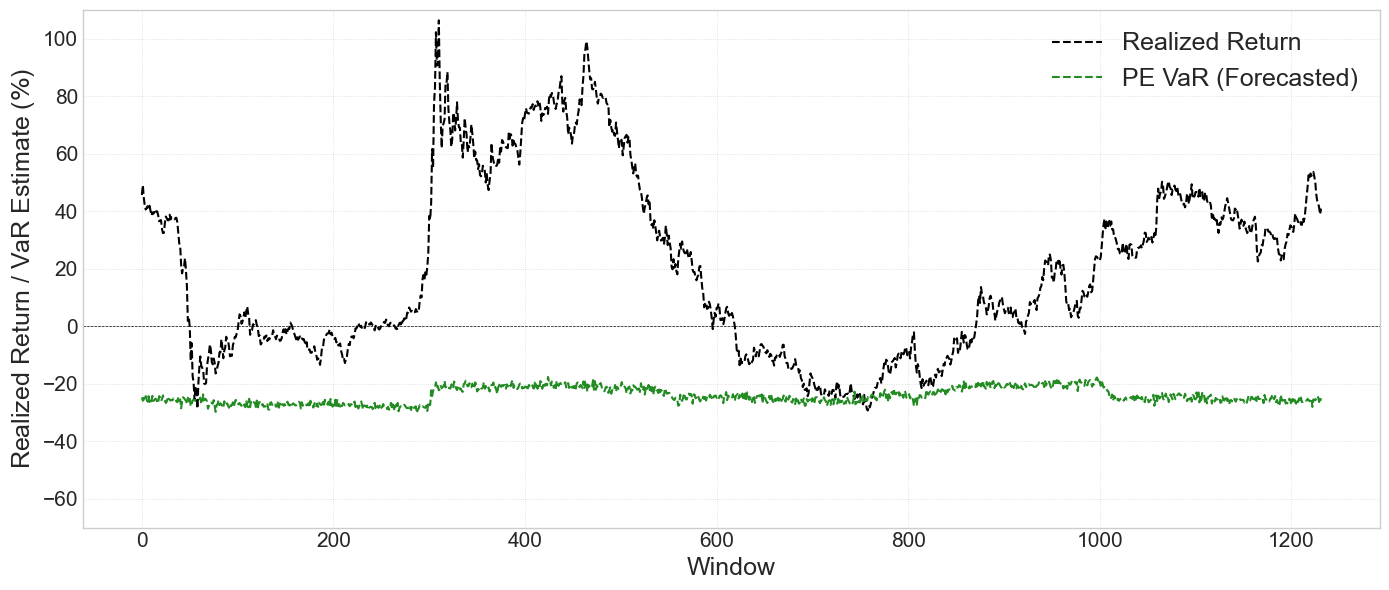

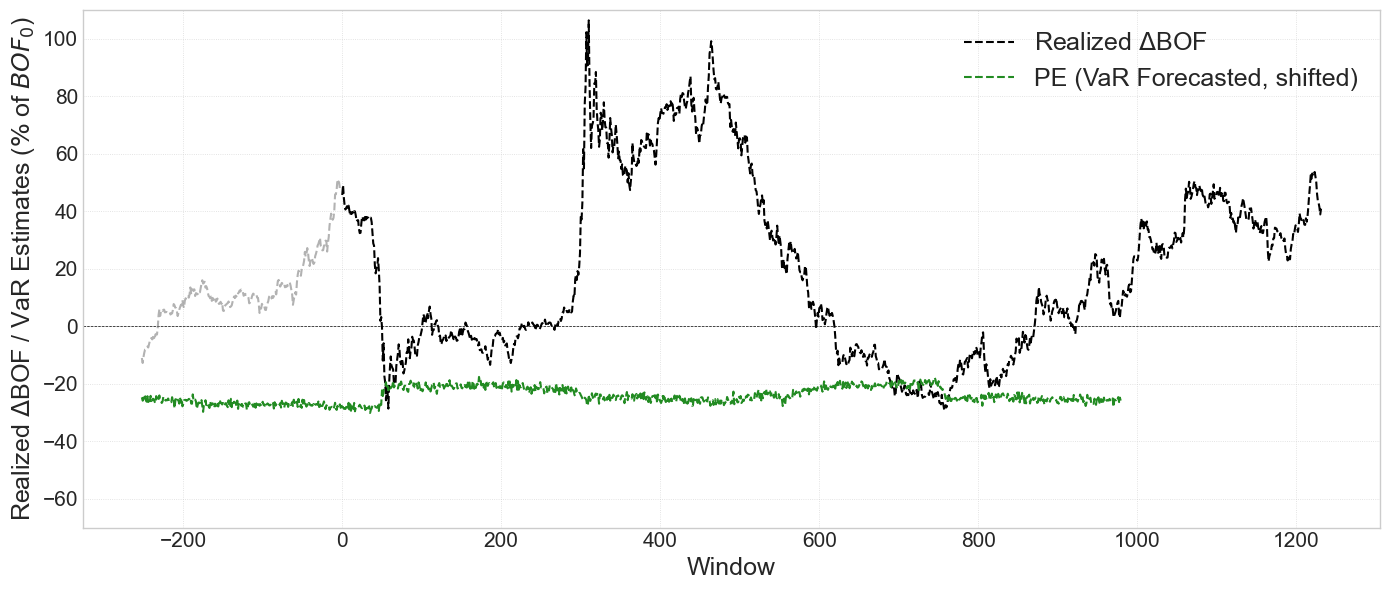

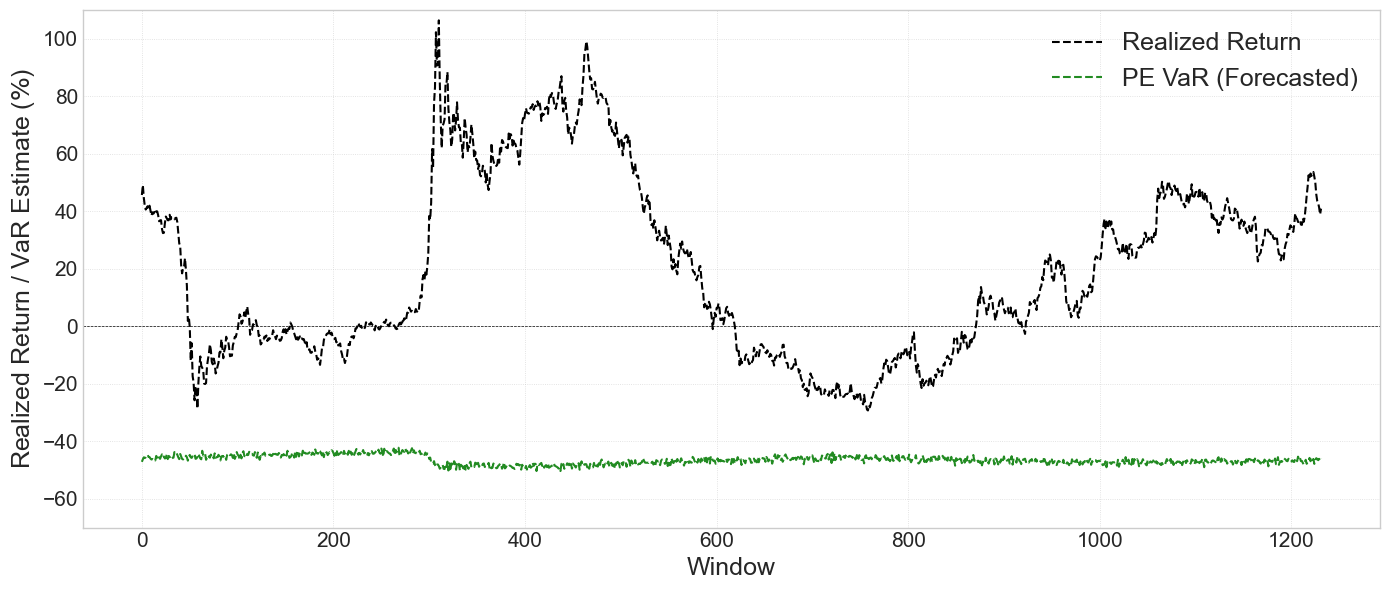

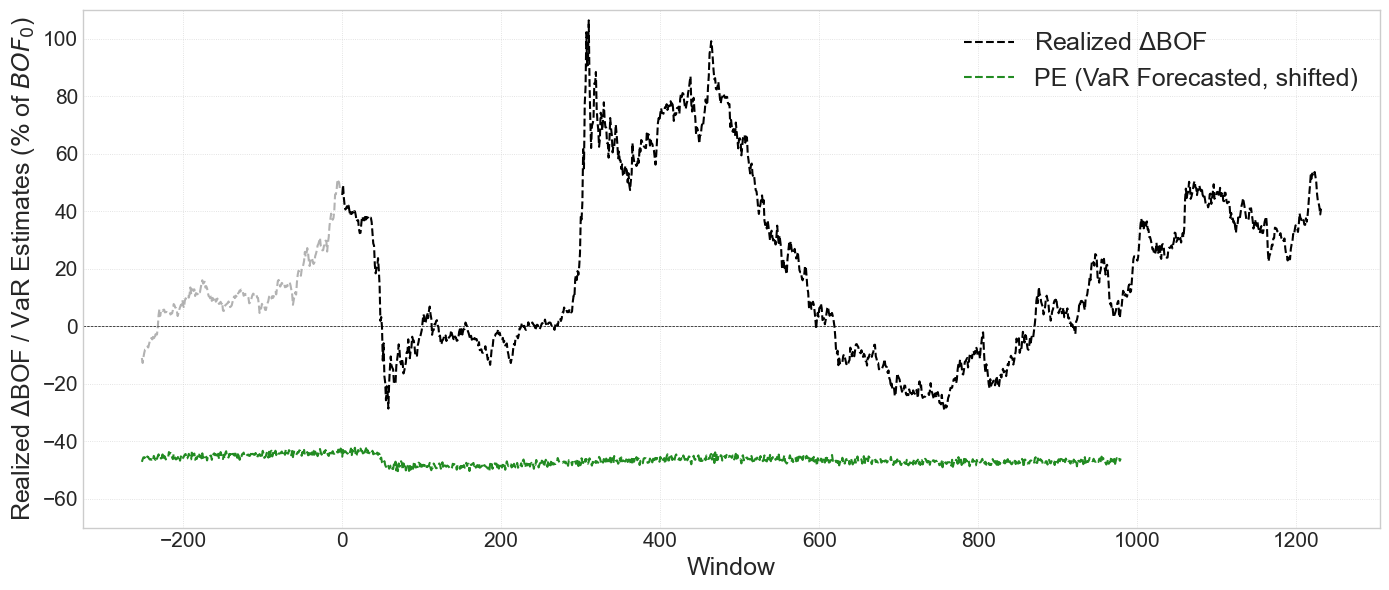

In [143]:
plot_single_forecast(
    df=pe,
    window_col='Window',
    realized_col='Realised Return',
    var_col='PE VaR (utcome-aligned)',
    label='PE VaR (Forecasted)'
)

plot_shifted(
    shifted['PE'],
    df1=pe,
    df2=pe,
    name='PE',
    col='PE VaR (utcome-aligned)',  
)

plot_single_forecast(
    df=pe_esg,
    window_col='Window',
    realized_col='Realised Return',
    var_col='PE VaR (utcome-aligned)',
    label='PE VaR (Forecasted)',
)

plot_shifted(
    shifted['PE'],
    df1=pe_esg,
    df2=pe_esg,
    name='PE',
    col='PE VaR (utcome-aligned)',  
)

### RE

In [144]:
reel = pd.read_csv('RE2.csv')
pd.set_option('display.float_format', '{:,.2f}'.format)
reel = unpack_and_explode_column(reel, 'SCR')
reel.rename(columns={'SCR': 'RE VaR (utcome-aligned)'}, inplace=True)
reel.rename(columns={'Realized_Delta_BOF': 'Realised Return'}, inplace=True)
reel = reel.reset_index().rename(columns={'index': 'Window'})
reel['RE VaR (utcome-aligned)'] = ((reel['RE VaR (utcome-aligned)'] - 1000000) / 1000000) * 100
reel['Realised Return'] = ((reel['Realised Return'] - 1000000) / 1000000) * 100
reel.head()

reel_esg = pd.read_csv('REEL_esg.csv')
pd.set_option('display.float_format', '{:,.2f}'.format)
reel_esg.rename(columns={'values': 'RE VaR (utcome-aligned)'}, inplace=True)
reel_esg['Realised Return'] = reel['Realised Return']
reel_esg['Window'] = reel['Window']
reel_esg['RE VaR (utcome-aligned)'] = ((reel_esg['RE VaR (utcome-aligned)'] - 1000000) / 1000000) * 100
reel_esg.head()

RE VaR (utcome-aligned)  Realised Return  Window
0                   -46.08            30.13       0
1                   -47.16            30.71       1
2                   -44.89            28.82       2
3                   -46.38            27.28       3
4                   -45.91            25.86       4

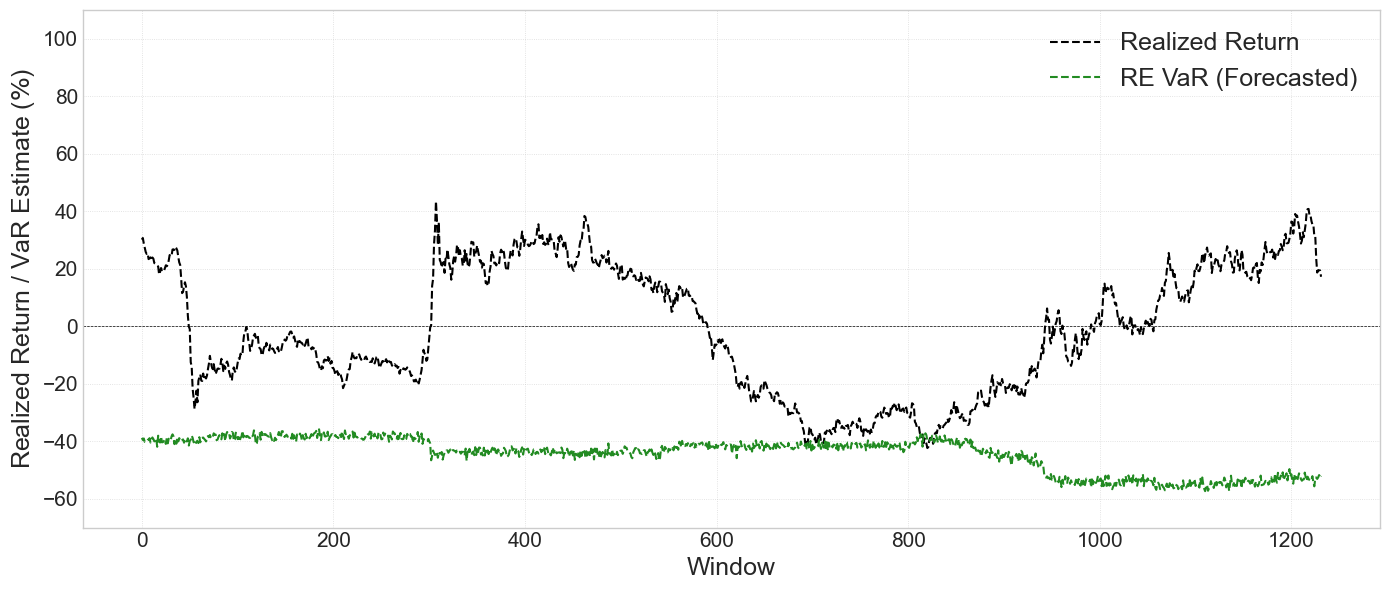

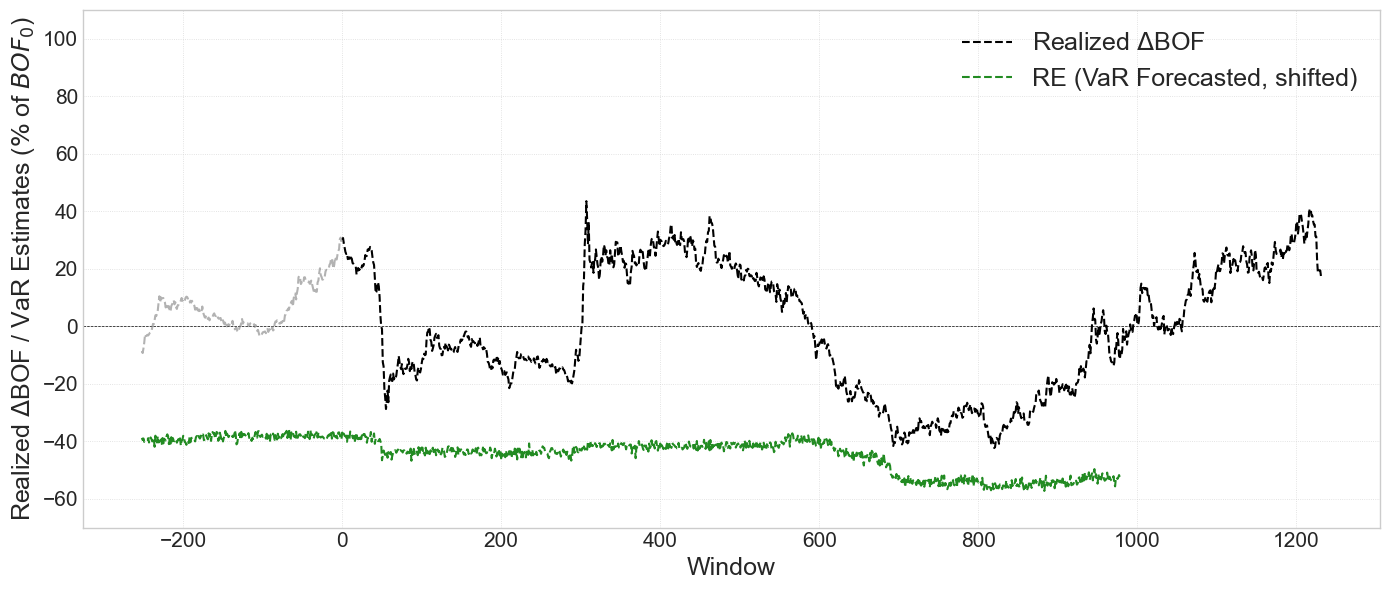

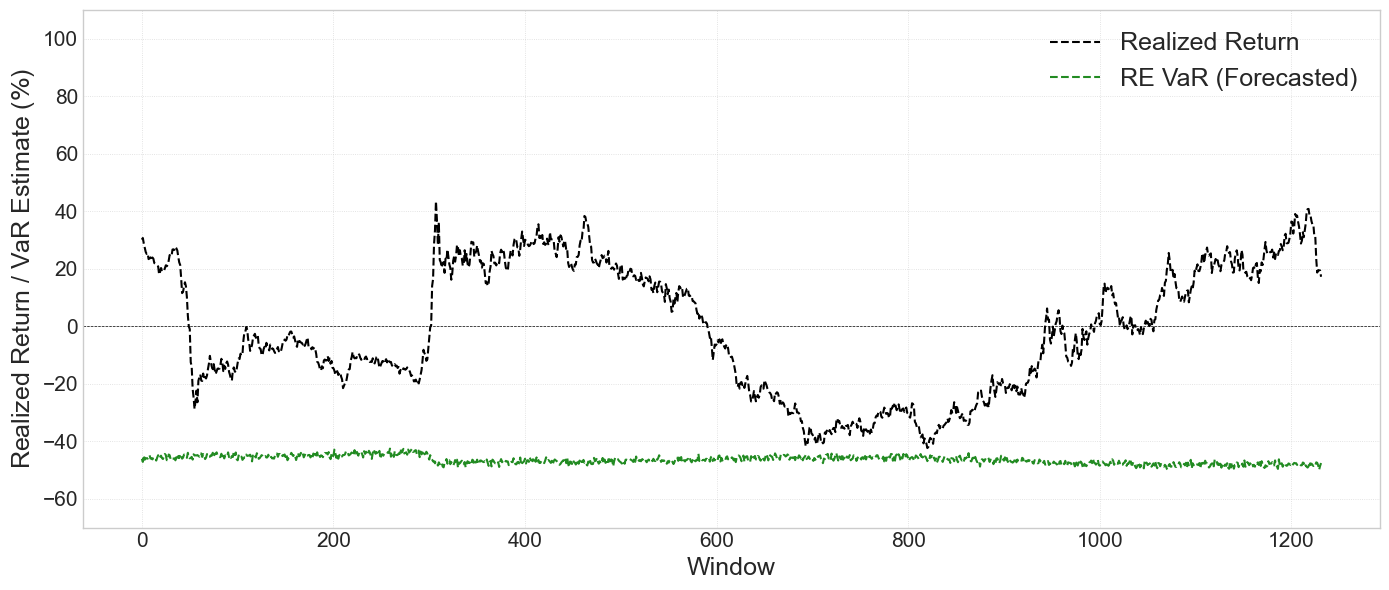

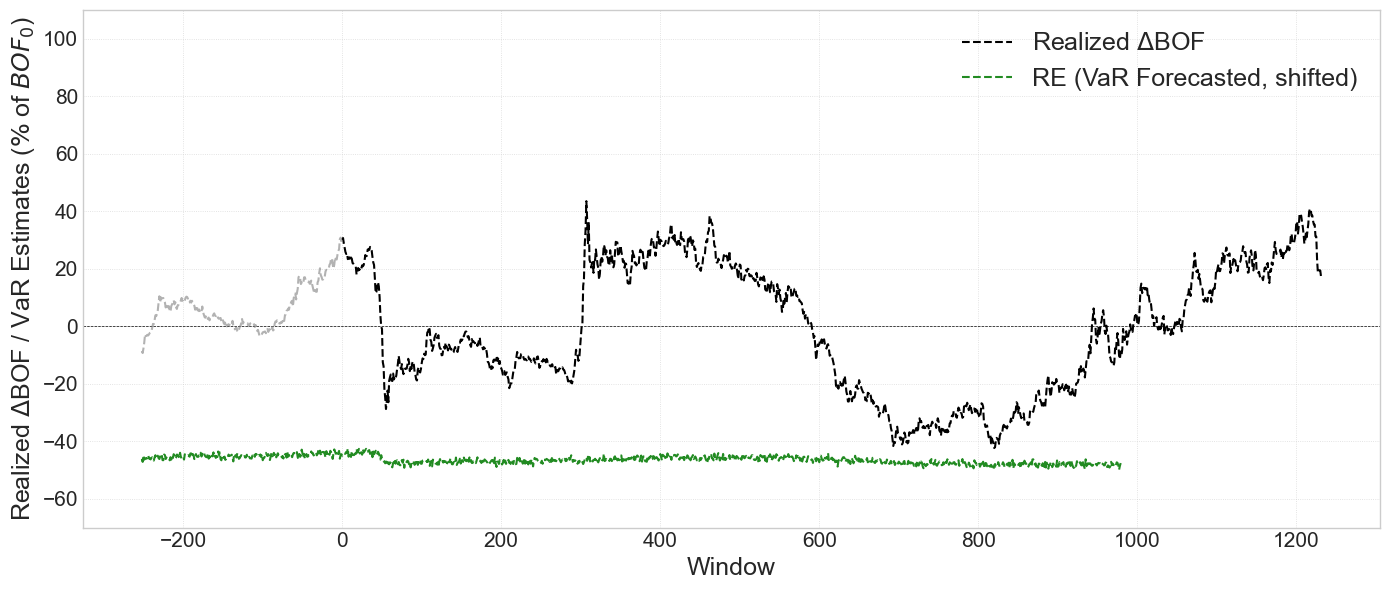

In [145]:
plot_single_forecast(
    df=reel,
    window_col='Window',
    realized_col='Realised Return',
    var_col='RE VaR (utcome-aligned)',
    label='RE VaR (Forecasted)'
)

plot_shifted(
    shifted['RE'],
    df1=reel,
    df2=reel,
    name='RE',
    col='RE VaR (utcome-aligned)',  
)

plot_single_forecast(
    df=reel_esg,
    window_col='Window',
    realized_col='Realised Return',
    var_col='RE VaR (utcome-aligned)',
    label='RE VaR (Forecasted)',
)

plot_shifted(
    shifted['RE'],
    df1=reel_esg,
    df2=reel_esg,
    name='RE',
    col='RE VaR (utcome-aligned)',  
)

### GB

In [146]:
gb = pd.read_csv('GB.csv')
pd.set_option('display.float_format', '{:,.2f}'.format)
gb = unpack_and_explode_column(gb, 'SCR')
gb.rename(columns={'SCR': 'GB VaR (utcome-aligned)'}, inplace=True)
gb.rename(columns={'Realized_Delta_BOF': 'Realised Return'}, inplace=True)
gb = gb.reset_index().rename(columns={'index': 'Window'})
gb['GB VaR (utcome-aligned)'] = ((gb['GB VaR (utcome-aligned)'] -
                                    1000000) / 1000000) * 100
gb['Realised Return'] = ((gb['Realised Return'] - 1000000) / 1000000) * 100
gb.head()

gb_esg = pd.read_csv('GOV_esg.csv')
pd.set_option('display.float_format', '{:,.2f}'.format)
gb_esg.rename(columns={'values': 'GB VaR (utcome-aligned)'}, inplace=True)
gb_esg['Realised Return'] = gb['Realised Return']
gb_esg['Window'] = gb['Window']
gb_esg['GB VaR (utcome-aligned)'] = ((gb_esg['GB VaR (utcome-aligned)'] - 1000000) / 1000000) * 100
gb_esg.head()

GB VaR (utcome-aligned)  Realised Return  Window
0                    -7.97             6.28       0
1                    -7.81             6.84       1
2                    -7.83             7.56       2
3                    -7.97             7.70       3
4                    -7.42             7.70       4

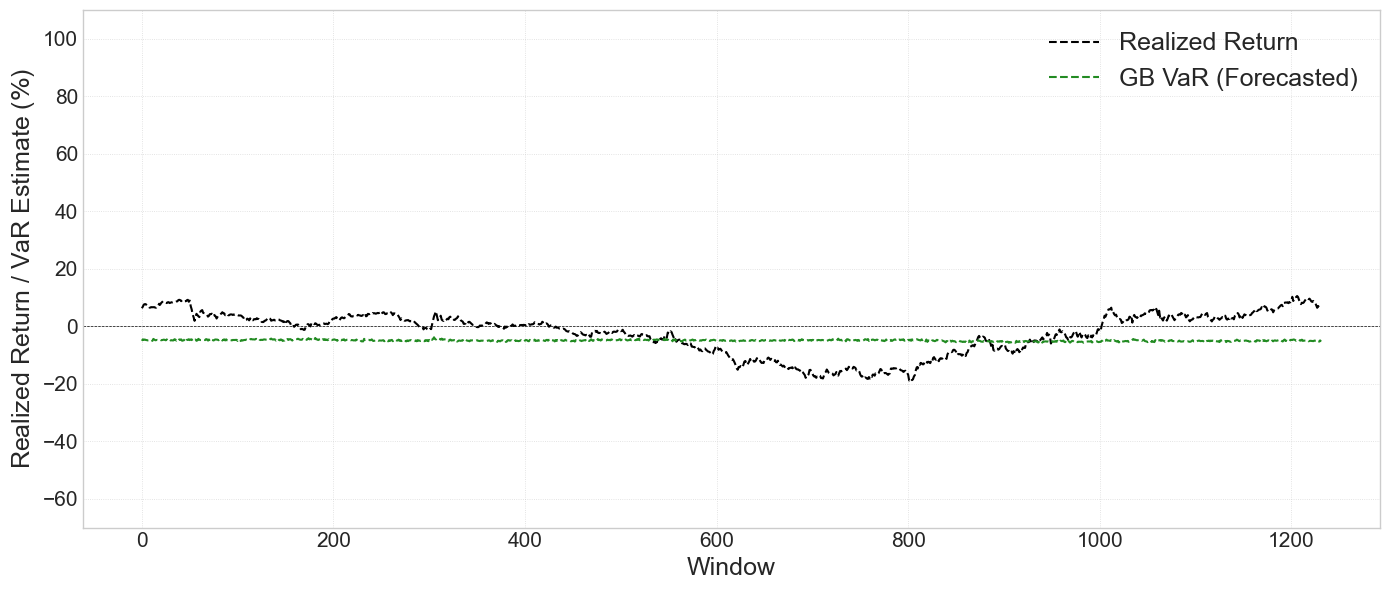

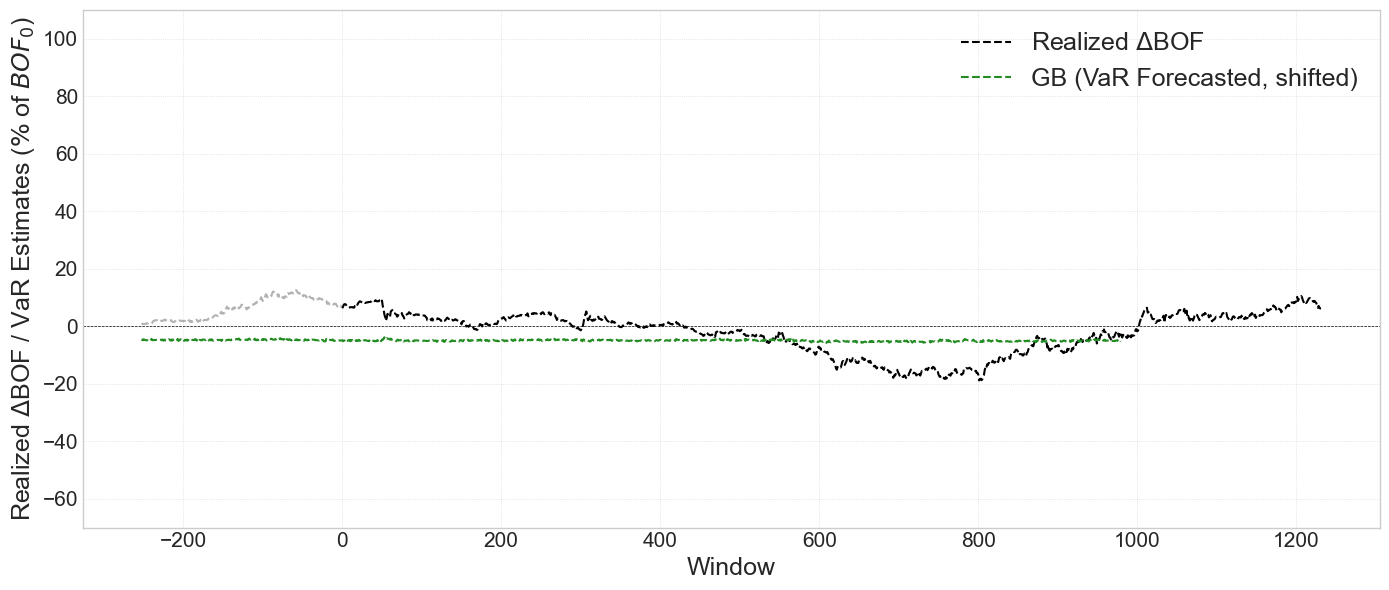

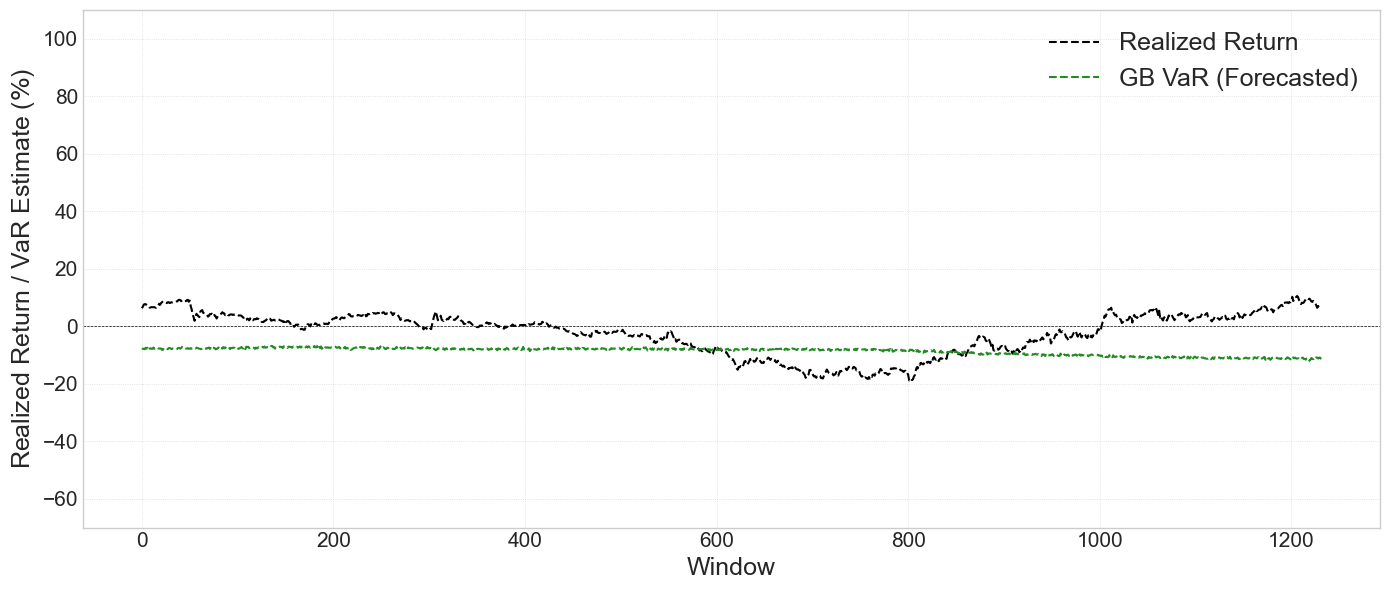

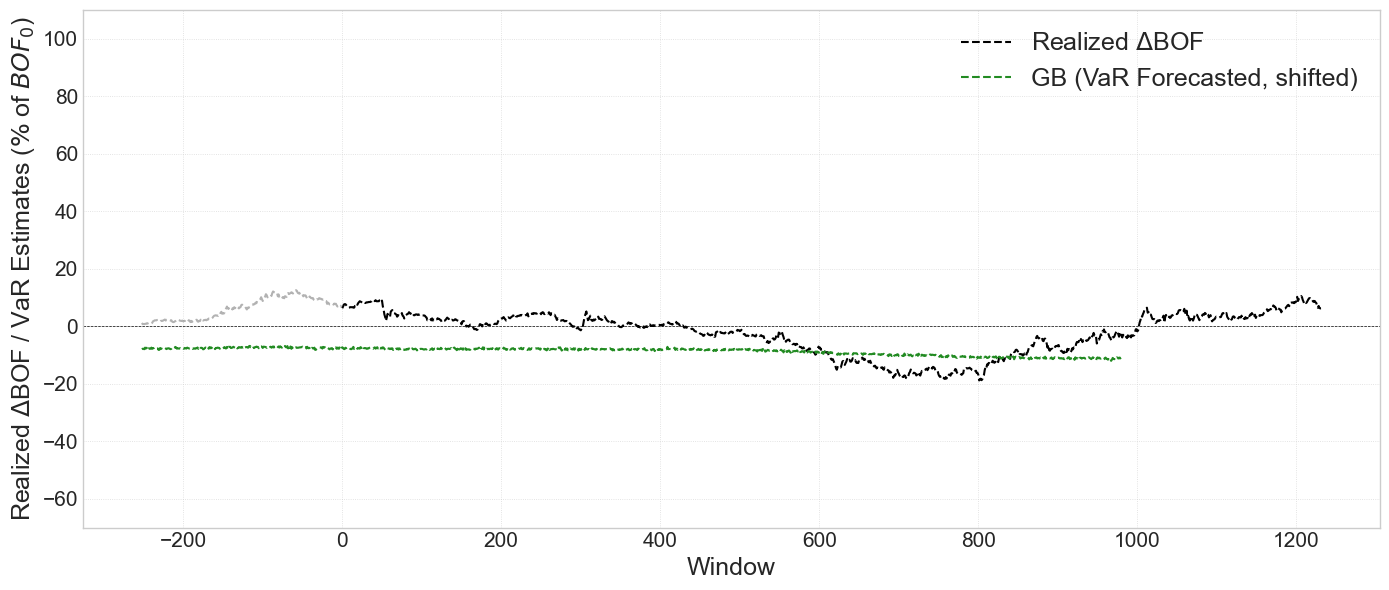

In [147]:
plot_single_forecast(
    df=gb,
    window_col='Window',
    realized_col='Realised Return',
    var_col='GB VaR (utcome-aligned)',
    label='GB VaR (Forecasted)'
)

plot_shifted(
    shifted['GB'],
    df1=gb,
    df2=gb,
    name='GB',
    col='GB VaR (utcome-aligned)',  
)

plot_single_forecast(
    df=gb_esg,
    window_col='Window',
    realized_col='Realised Return',
    var_col='GB VaR (utcome-aligned)',
    label='GB VaR (Forecasted)'
)

plot_shifted(
    shifted['GB'],
    df1=gb_esg,
    df2=gb_esg,
    name='GB',
    col='GB VaR (utcome-aligned)',  
)



### IG CB

In [148]:
ig_cb = pd.read_csv('IG CB.csv')
pd.set_option('display.float_format', '{:,.2f}'.format)
ig_cb = unpack_and_explode_column(ig_cb, 'SCR')
ig_cb.rename(columns={'SCR': 'IG CB VaR (utcome-aligned)'}, inplace=True)
ig_cb.rename(columns={'Realized_Delta_BOF': 'Realised Return'}, inplace=True)
ig_cb = ig_cb.reset_index().rename(columns={'index': 'Window'})
ig_cb['IG CB VaR (utcome-aligned)'] = ((ig_cb['IG CB VaR (utcome-aligned)'] -
                                  1000000) / 1000000) * 100
ig_cb['Realised Return'] = (
    (ig_cb['Realised Return'] - 1000000) / 1000000) * 100
ig_cb.head()

ig_cb_esg = pd.read_csv('IG_esg.csv')
pd.set_option('display.float_format', '{:,.2f}'.format)
ig_cb_esg.rename(columns={'values': 'IG CB VaR (utcome-aligned)'}, inplace=True)
ig_cb_esg['Realised Return'] = ig_cb['Realised Return']
ig_cb_esg['Window'] = ig_cb['Window']
ig_cb_esg['IG CB VaR (utcome-aligned)'] = ((ig_cb_esg['IG CB VaR (utcome-aligned)'] - 1000000) / 1000000) * 100
ig_cb_esg.head()

IG CB VaR (utcome-aligned)  Realised Return  Window
0                       -6.40            10.97       0
1                       -6.33            10.85       1
2                       -6.35            11.82       2
3                       -6.47            11.62       3
4                       -6.04            11.55       4

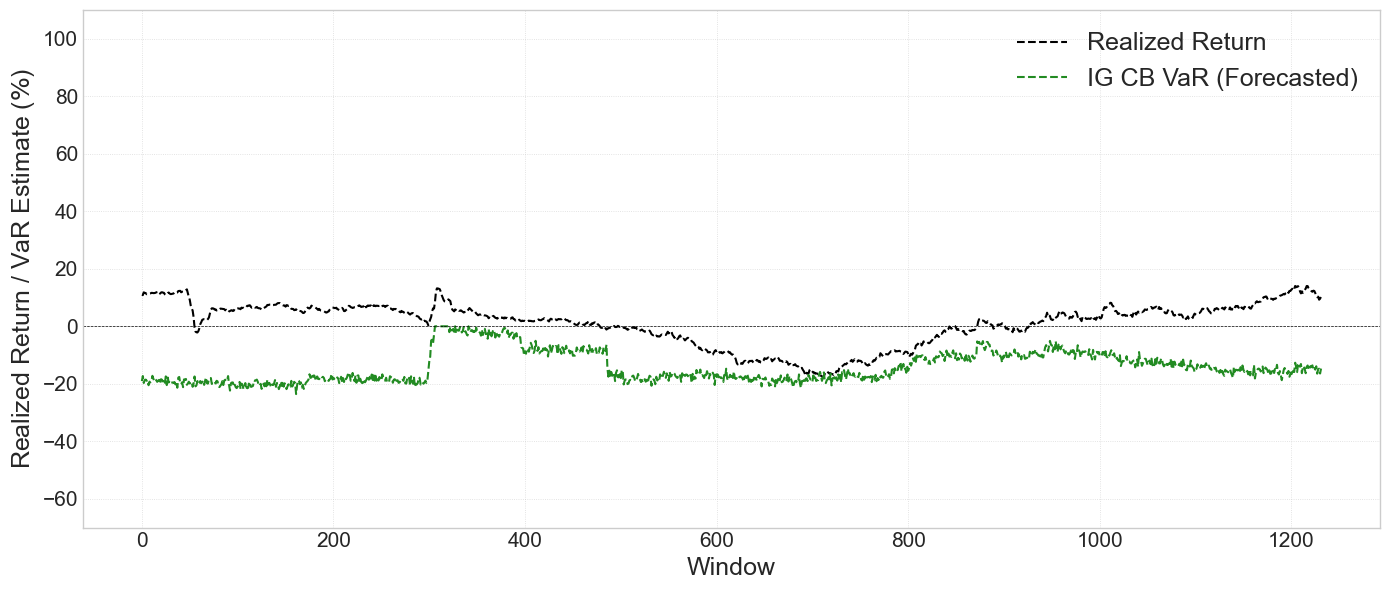

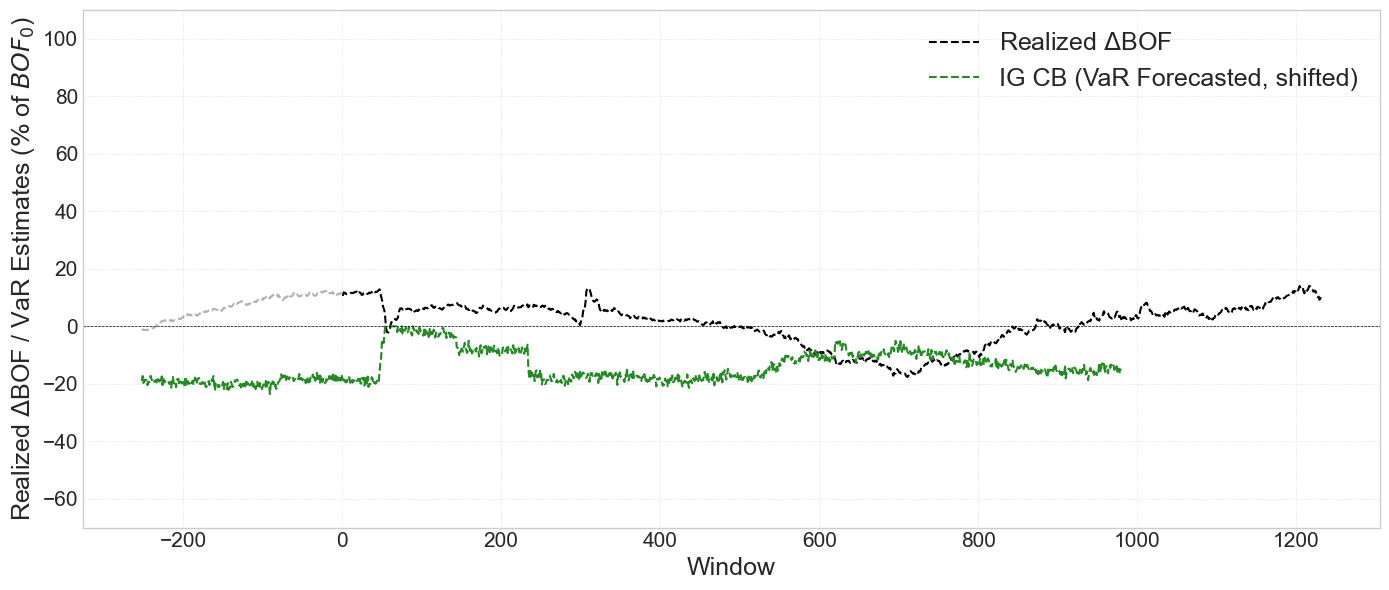

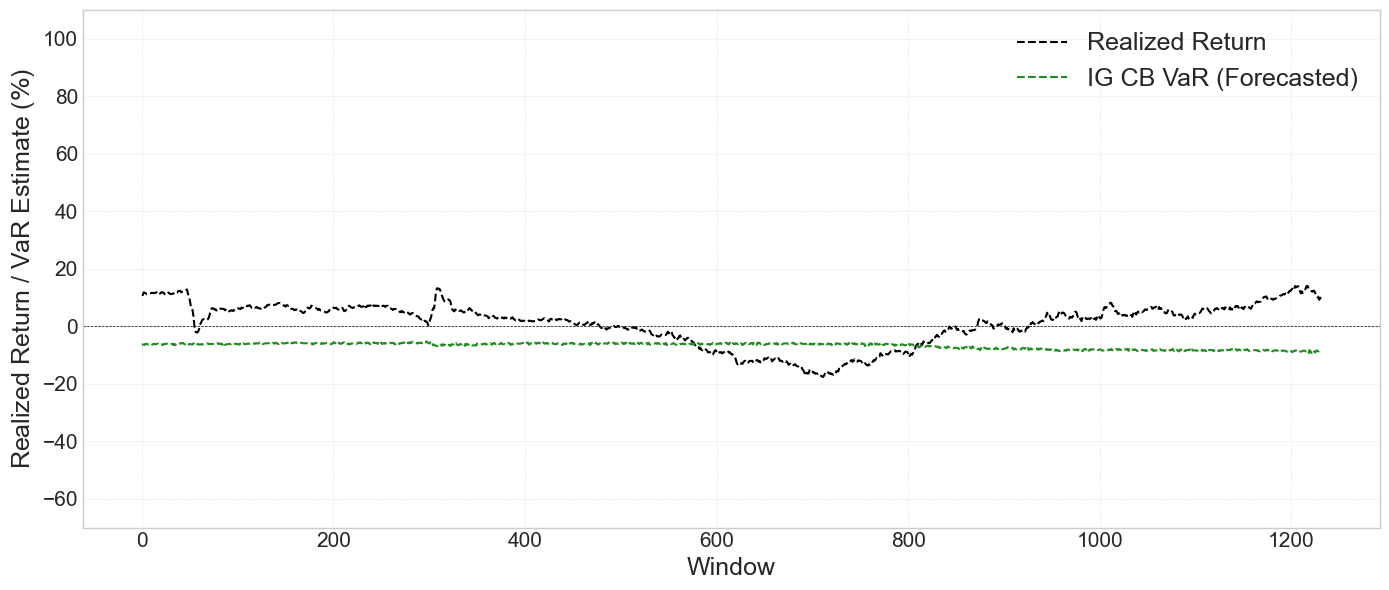

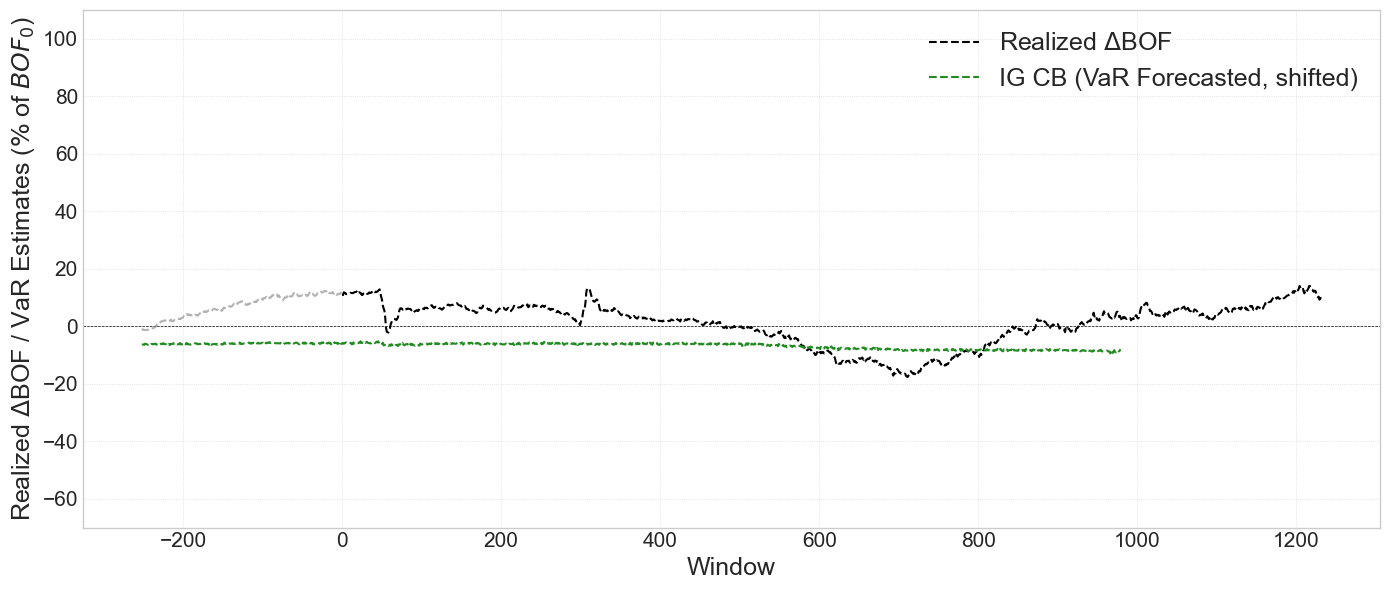

In [149]:
plot_single_forecast(
    df=ig_cb,
    window_col='Window',
    realized_col='Realised Return',
    var_col='IG CB VaR (utcome-aligned)',
    label='IG CB VaR (Forecasted)'
)

plot_shifted(
    shifted['IG CB'],
    df1=ig_cb,
    df2=ig_cb,
    name='IG CB',
    col='IG CB VaR (utcome-aligned)',  
)

plot_single_forecast(
    df=ig_cb_esg,
    window_col='Window',
    realized_col='Realised Return',
    var_col='IG CB VaR (utcome-aligned)',
    label='IG CB VaR (Forecasted)'
)

plot_shifted(
    shifted['IG CB'],
    df1=ig_cb_esg,
    df2=ig_cb_esg,
    name='IG CB',
    col='IG CB VaR (utcome-aligned)',  
)

### HY CB

In [150]:
hy_cb = pd.read_csv('HY CB.csv')
pd.set_option('display.float_format', '{:,.2f}'.format)
hy_cb = unpack_and_explode_column(hy_cb, 'SCR')
hy_cb.rename(columns={'SCR': 'HY CB VaR (utcome-aligned)'}, inplace=True)
hy_cb.rename(columns={'Realized_Delta_BOF': 'Realised Return'}, inplace=True)
hy_cb = hy_cb.reset_index().rename(columns={'index': 'Window'})
hy_cb['HY CB VaR (utcome-aligned)'] = ((hy_cb['HY CB VaR (utcome-aligned)'] -
                                        1000000) / 1000000) * 100
hy_cb['Realised Return'] = (
    (hy_cb['Realised Return'] - 1000000) / 1000000) * 100
hy_cb.head()

hy_cb_esg = pd.read_csv('HY_esg.csv')
pd.set_option('display.float_format', '{:,.2f}'.format)
hy_cb_esg.rename(columns={'values': 'HY CB VaR (utcome-aligned)'}, inplace=True)
hy_cb_esg['Realised Return'] = hy_cb['Realised Return']
hy_cb_esg['Window'] = hy_cb['Window']
hy_cb_esg['HY CB VaR (utcome-aligned)'] = ((hy_cb_esg['HY CB VaR (utcome-aligned)'] - 1000000) / 1000000) * 100
hy_cb_esg.head()

HY CB VaR (utcome-aligned)  Realised Return  Window
0                       -9.19            14.00       0
1                       -9.02            14.13       1
2                       -8.75            13.43       2
3                       -8.62            12.82       3
4                       -8.47            12.42       4

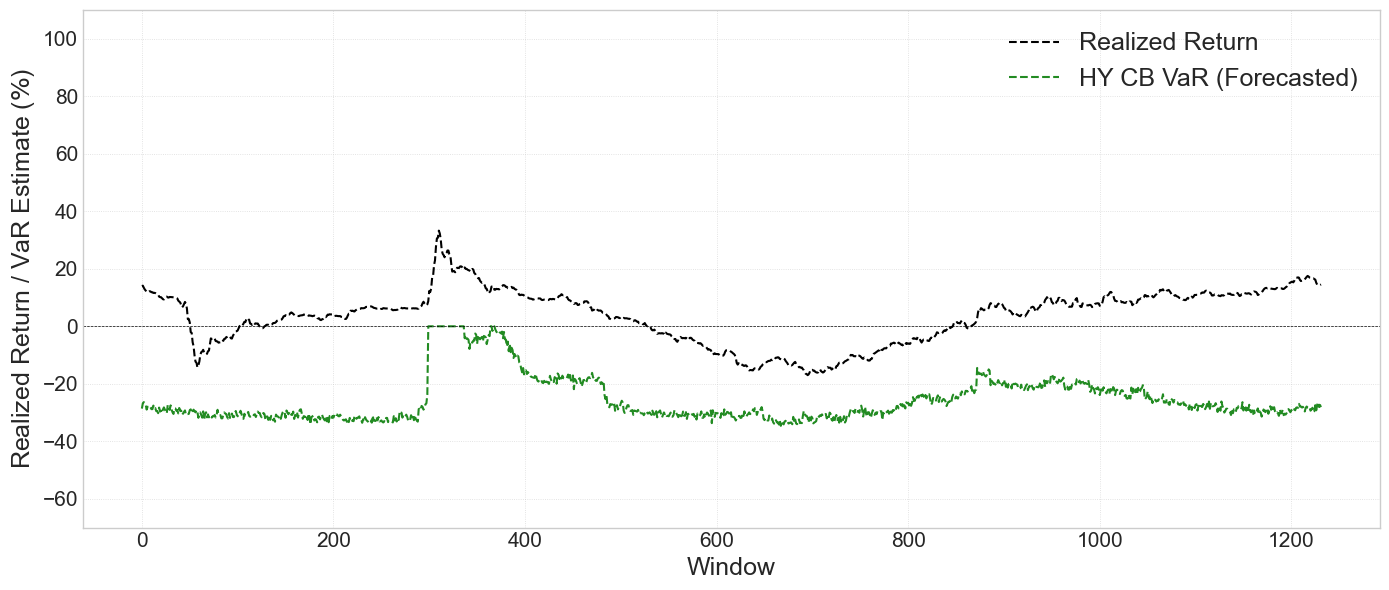

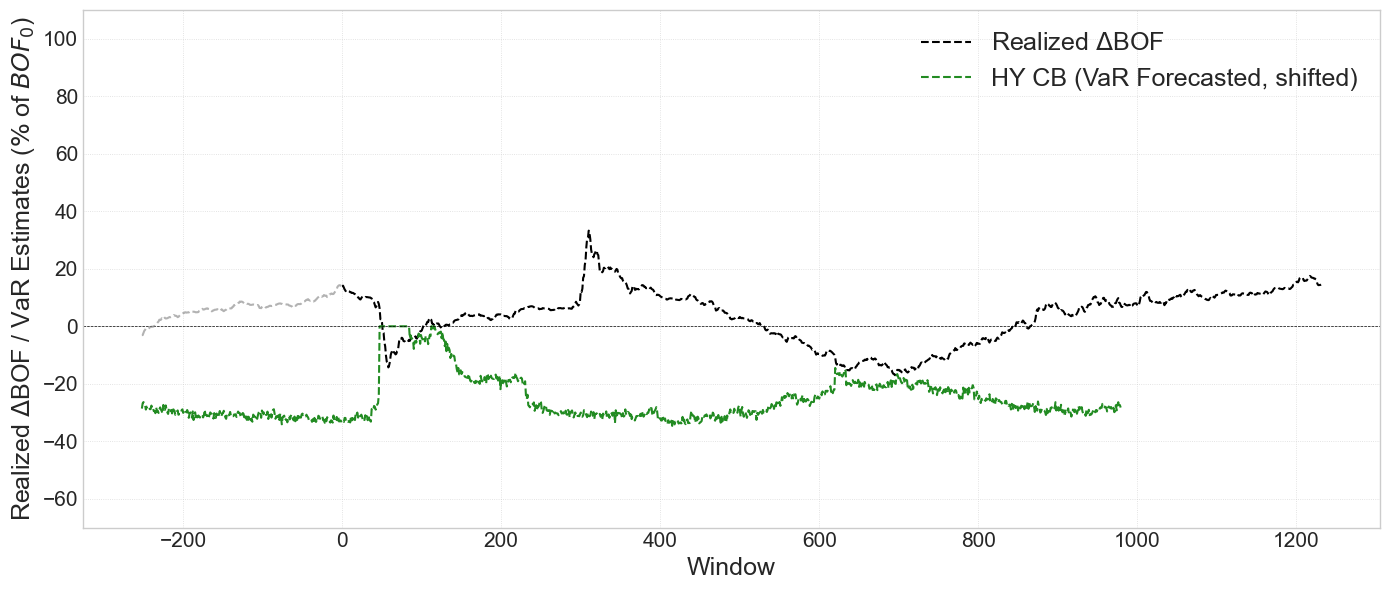

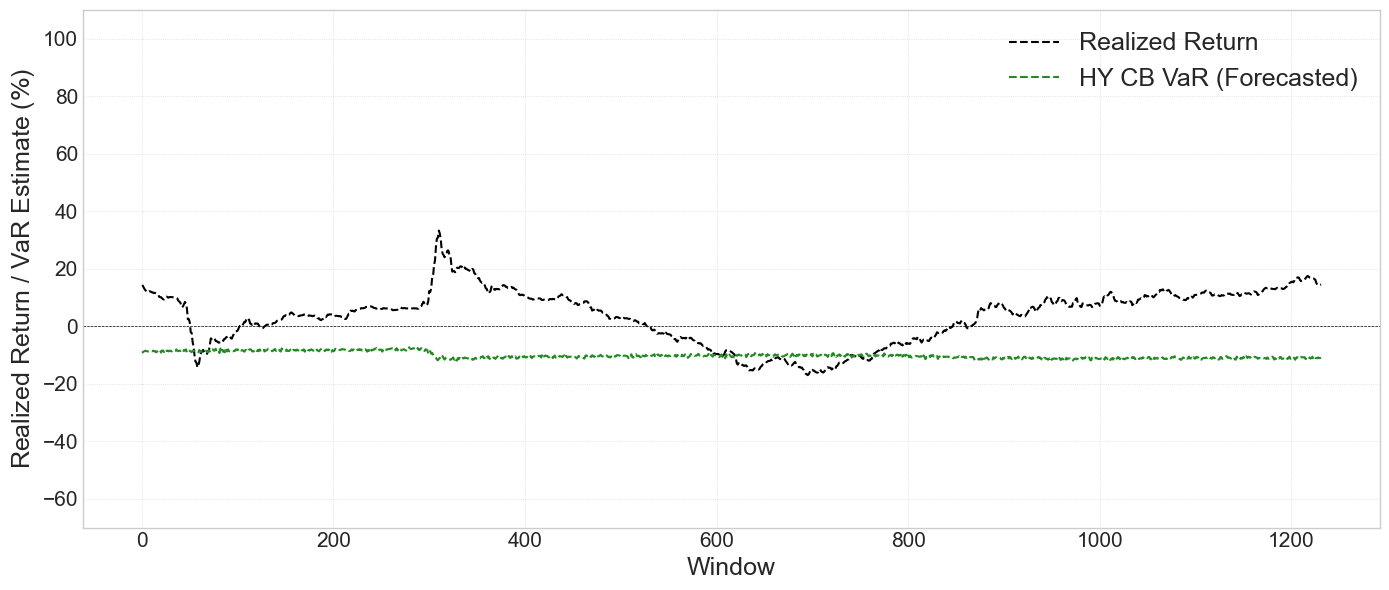

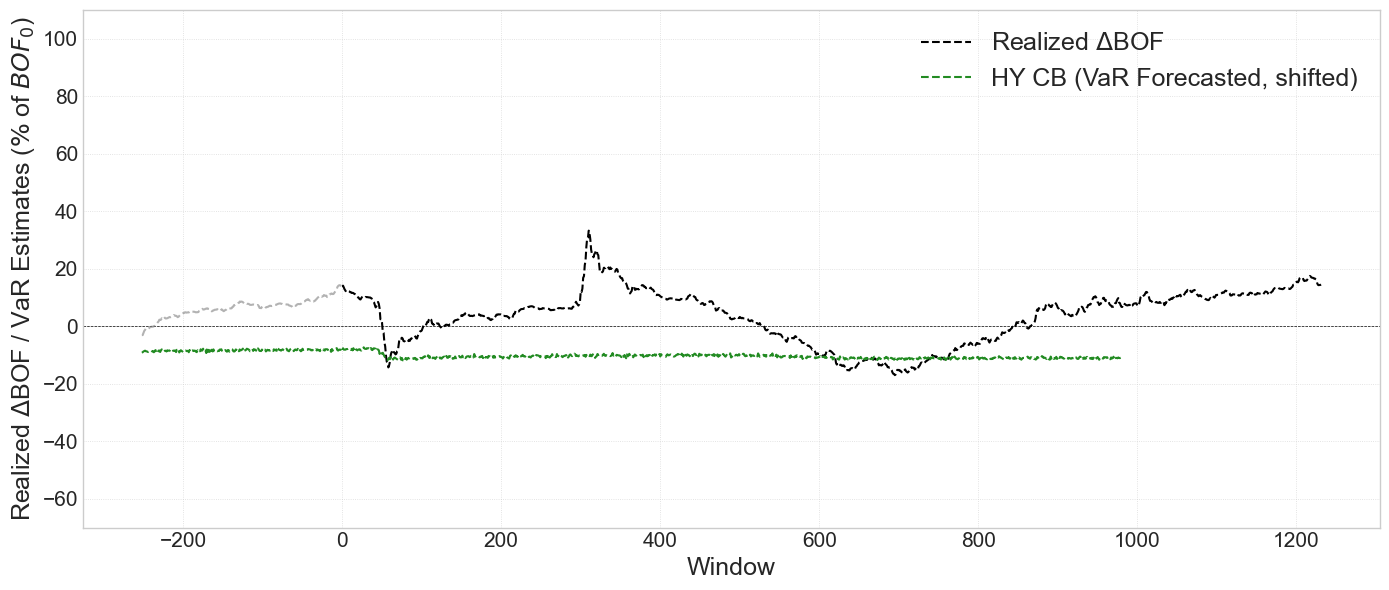

In [151]:
plot_single_forecast(
    df=hy_cb,
    window_col='Window',
    realized_col='Realised Return',
    var_col='HY CB VaR (utcome-aligned)',
    label='HY CB VaR (Forecasted)'
)

plot_shifted(
    shifted['HY CB'],
    df1=hy_cb,
    df2=hy_cb,
    name='HY CB',
    col='HY CB VaR (utcome-aligned)',  
)

plot_single_forecast(
    df=hy_cb_esg,
    window_col='Window',
    realized_col='Realised Return',
    var_col='HY CB VaR (utcome-aligned)',
    label='HY CB VaR (Forecasted)'
)

plot_shifted(
    shifted['HY CB'],
    df1=hy_cb_esg,
    df2=hy_cb_esg,
    name='HY CB',
    col='HY CB VaR (utcome-aligned)',  
)

### Money

In [152]:
money = pd.read_csv('money_2.csv')
pd.set_option('display.float_format', '{:,.2f}'.format)
money = unpack_and_explode_column(money, 'SCR')
money.rename(columns={'SCR': 'Money VaR (utcome-aligned)'}, inplace=True)
money.rename(columns={'Realized_Delta_BOF': 'Realised Return'}, inplace=True)
money = money.reset_index().rename(columns={'index': 'Window'})
money['Money VaR (utcome-aligned)'] = ((money['Money VaR (utcome-aligned)'] -
                                        1000000) / 1000000) * 100
money['Realised Return'] = (
    (money['Realised Return'] - 1000000) / 1000000) * 100
money.head()

money_esg = pd.read_csv('EONIA_esg.csv')
pd.set_option('display.float_format', '{:,.2f}'.format)
money_esg.rename(columns={'values': 'Money VaR (utcome-aligned)'}, inplace=True)
money_esg['Realised Return'] = money['Realised Return']
money_esg['Window'] = money['Window']
money_esg['Money VaR (utcome-aligned)'] = ((money_esg['Money VaR (utcome-aligned)'] - 1000000) / 1000000) * 100
money_esg.head()

Money VaR (utcome-aligned)  Realised Return  Window
0                      -12.56            -0.40       0
1                      -12.78            -0.40       1
2                      -12.59            -0.41       2
3                      -13.74            -0.41       3
4                      -12.78            -0.41       4

In [153]:
shifted.head()

EQ     PE    RE  IG CB  HY CB   GB  MONEY
0 -5.76 -11.03 -8.60  -1.30  -3.05 1.15  -0.36
1 -7.98 -12.75 -9.30  -1.03  -3.06 0.76  -0.35
2 -6.14 -10.71 -7.66  -1.24  -2.37 0.81  -0.35
3 -5.41  -9.22 -5.63  -1.24  -1.60 0.75  -0.36
4 -4.36  -8.10 -2.77  -1.35  -1.25 0.86  -0.36

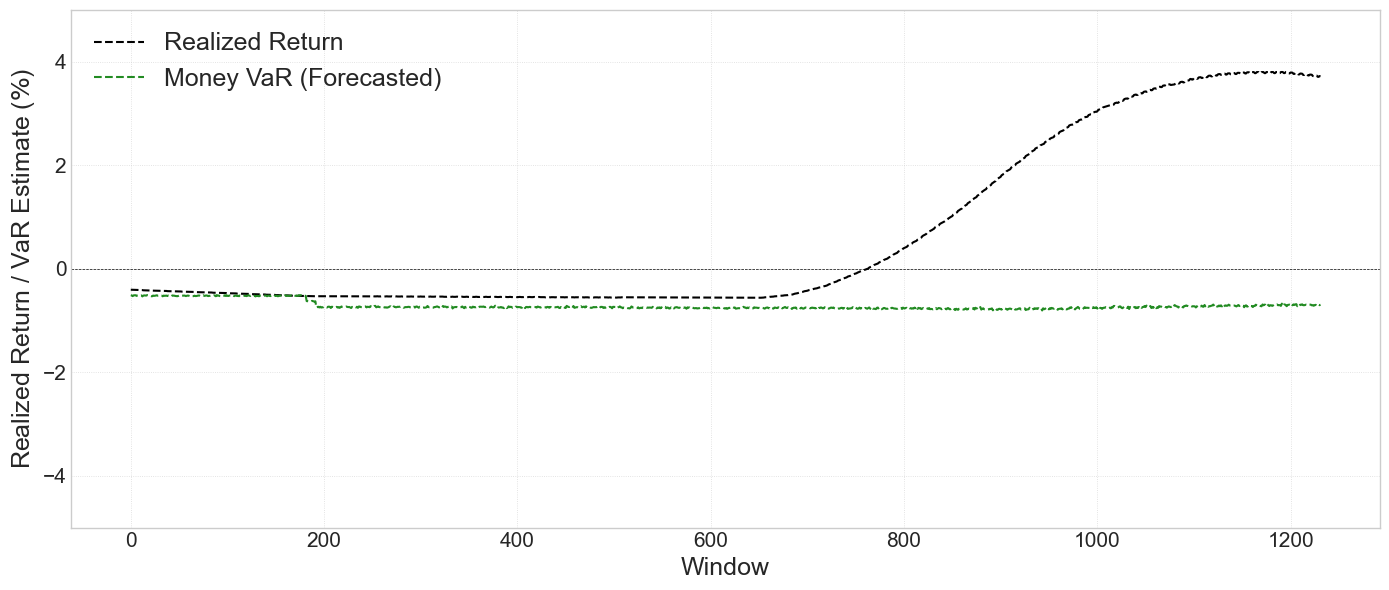

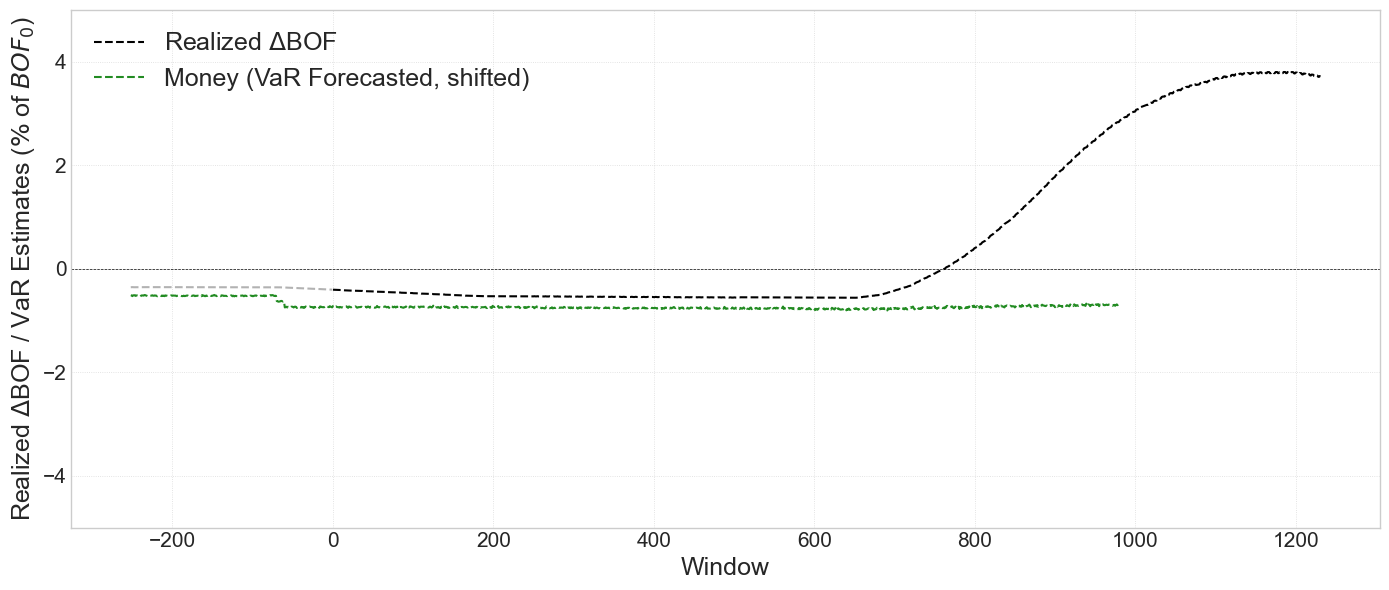

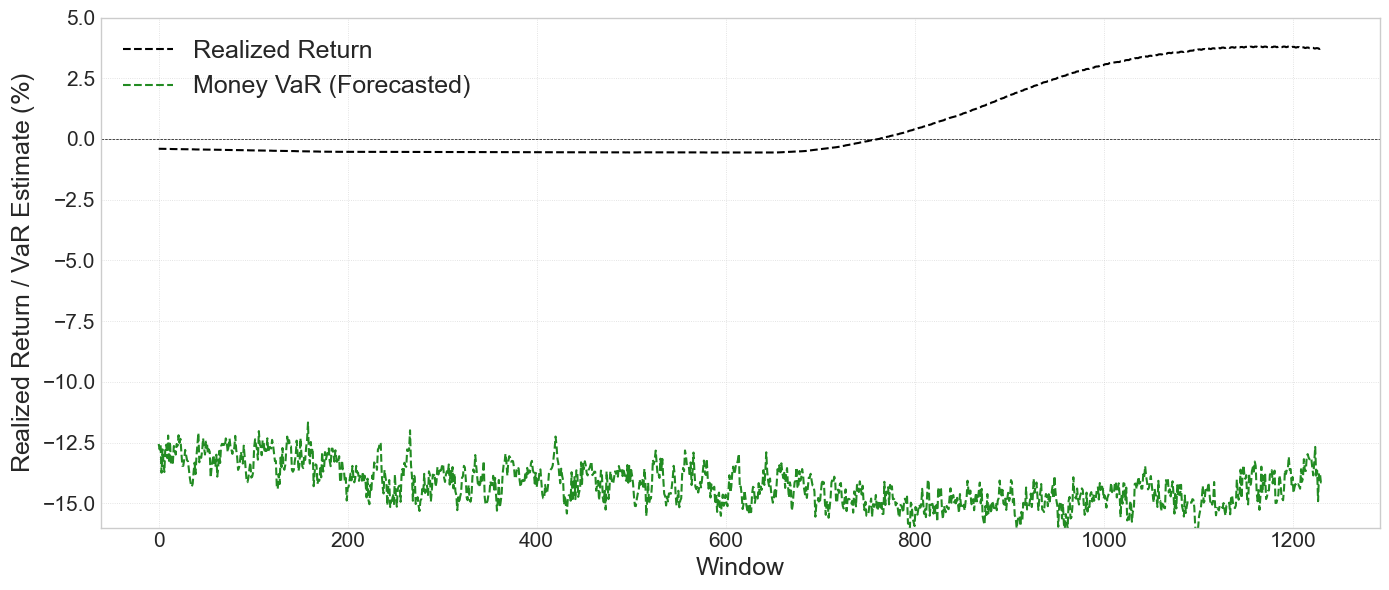

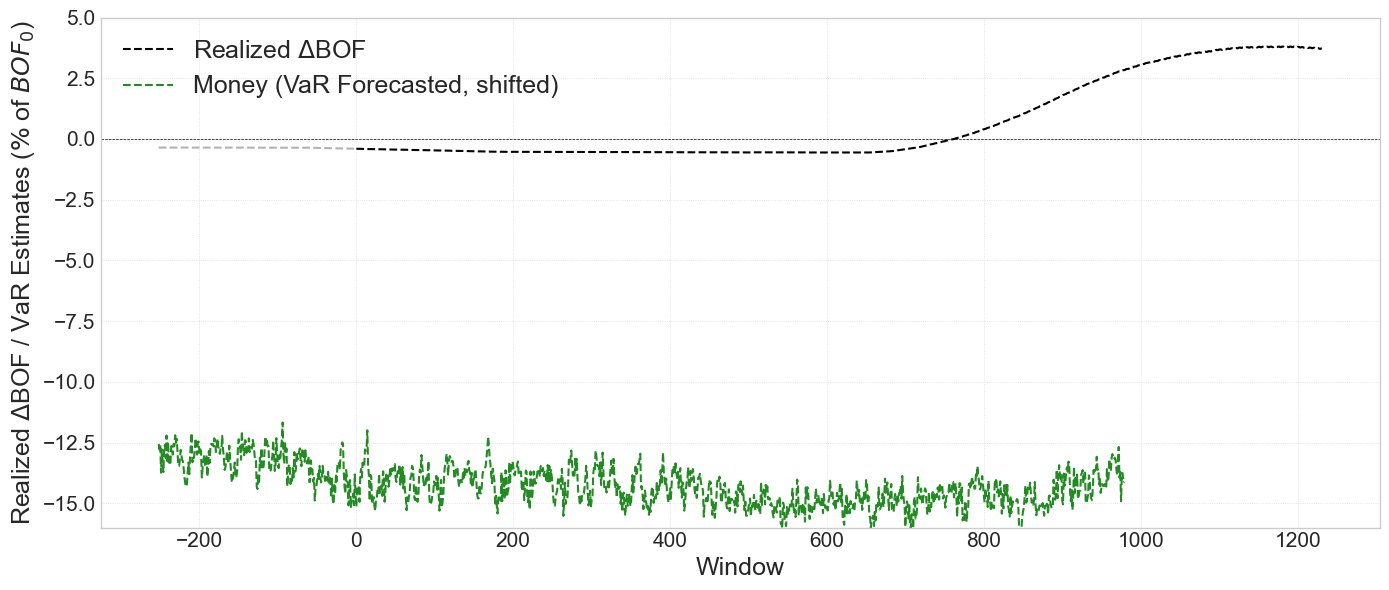

In [154]:
plot_single_forecast(
    df=money,
    window_col='Window',
    realized_col='Realised Return',
    var_col='Money VaR (utcome-aligned)',
    label='Money VaR (Forecasted)',
    bounds=(-5,5)
)

plot_shifted(
    shifted['MONEY'],
    df1=money,
    df2=money,
    name='Money',
    col='Money VaR (utcome-aligned)',  
    bounds=(-5,5)
)

plot_single_forecast(
    df=money_esg,
    window_col='Window',
    realized_col='Realised Return',
    var_col='Money VaR (utcome-aligned)',
    label='Money VaR (Forecasted)',
    bounds=(-16,5)
)

plot_shifted(
    shifted['MONEY'],
    df1=money_esg,
    df2=money_esg,
    name='Money',
    col='Money VaR (utcome-aligned)',  
    bounds=(-16,5)
)